# Steps for training detectron2 on custom data

### Loading necessary libraries

In [1]:
import h5py
import os
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd
import random
import time
%config Completer.use_jedi = False


os.chdir("C:/Users/admin/Documents/Python Scripts/Soma-Segmentation/train")
from utils import ImageJ2COCO
from config import configuration
from segmentation_predictor import predict_img


#from train import run_train
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer

from detectron2.config import get_cfg
from detectron2 import model_zoo

from detectron2.data import MetadataCatalog, DatasetCatalog

import detectron2.data.transforms as T
from detectron2.data import DatasetMapper   # the default mapper
from detectron2.data import build_detection_train_loader, build_detection_test_loader

from detectron2.evaluation import COCOEvaluator, inference_on_dataset

from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer

from detectron2.engine import DefaultPredictor

### Registering data

In [2]:
# if data already is in COCO style
register_coco_instances("train", {}, "I:/Sina/Medical report segmentation/publaynet/train.json", 
                        "I:/Sina/Medical report segmentation/publaynet/train")
register_coco_instances("val", {}, "I:/Sina/Medical report segmentation/publaynet/val.json", 
                        "I:/Sina/Medical report segmentation/publaynet/val")


#MetadataCatalog.get("val").set(thing_classes=["title", "text", "figure", "table", "list"])
#MetadataCatalog.get("train").set(thing_classes=["title", "text", "figure", "table", "list"])

In [2]:
# for custom data with custom written dataloader

# dataloader for train dataset (this custom written data loader is able to load multple datasets from different location)
img2coco_train = ImageJ2COCO(image_path=["G:/Data & Analysis/150802_p3.5_gcamp6/Data/150802_p3.5_gcamp6 H5/150802_a3_1h40min.h5",
                                   "G:/Data & Analysis/150802_p3.5_gcamp6/Data/150802_p3.5_gcamp6 H5/150802_a3_1h40min.h5"], 
                           label_path=["G:/Data & Analysis/150802_p3.5_gcamp6/Analysis/ROIS and Inside Activities/RoiSetFull.zip", 
                                       "G:/Data & Analysis/150802_p3.5_gcamp6/Analysis/ROIS and Inside Activities/RoiSetFull.zip"], 
                           output_path="C:/Users/admin/Desktop/test", 
                           start_index=[10000, 12000], 
                           end_index=[12000, 14000], 
                           image_nr=[1400, 1500], 
                           id_starter=[1, 2000], 
                           min_intensity = [100, 100], 
                           max_intensity = [4000, 3000], 
                           image_scale = [(128,128), (128,128)], 
                           image_rotation = [-90, -90],
                           key = ["GroupHierarchy.Groups.Datasets", 
                                  "GroupHierarchy.Groups.Datasets"])

# dataloader for validation dataset (this custom written data loader is able to load multple datasets from different location)
img2coco_val = ImageJ2COCO(image_path=["G:/Data & Analysis/150802_p3.5_gcamp6/Data/150802_p3.5_gcamp6 H5/150802_a3_1h40min.h5",
                                   "G:/Data & Analysis/150802_p3.5_gcamp6/Data/150802_p3.5_gcamp6 H5/150802_a3_1h40min.h5"], 
                           label_path=["G:/Data & Analysis/150802_p3.5_gcamp6/Analysis/ROIS and Inside Activities/RoiSetFull.zip", 
                                       "G:/Data & Analysis/150802_p3.5_gcamp6/Analysis/ROIS and Inside Activities/RoiSetFull.zip"], 
                           output_path="C:/Users/admin/Desktop/test", 
                           start_index=[1000, 1200], 
                           end_index=[20000, 40000], 
                           image_nr=[800, 800], 
                           id_starter=[3000, 4000], 
                           min_intensity = [100, 100], 
                           max_intensity = [4000, 3000], 
                           image_scale = [(128,128), (128,128)], 
                           image_rotation = [-90, -90],
                           key = ["GroupHierarchy.Groups.Datasets", 
                                  "GroupHierarchy.Groups.Datasets"])

# register train data set
DatasetCatalog.register("train", img2coco_train.transform)
MetadataCatalog.get("train").set(thing_classes=["soma"]) # define classes as well

# register validation data set
DatasetCatalog.register("val", img2coco_val.transform)
MetadataCatalog.get("val").set(thing_classes=["soma"]) # define classes as well

metadata = MetadataCatalog.get("train")

### Check visually the data load step

In [3]:
# prepare data

mydata = DatasetCatalog.get("train")
mydata_metdata = MetadataCatalog.get("train")

step 1: reading imageJ ROIs
Total number of ROIs are: 10
step 2: loading video in h5 format
All keys; 
         GroupHierarchy.Groups.Datasets
step 3: transfering video to images
start saving images!


100%|█████████████████████████████████████| 1400/1400 [00:03<00:00, 434.08it/s]


step 4: creating annotation dictionary
step 5: converting to COCO style dataset
start to write COCO style dataset!


100%|█████████████████████████████████████| 4002/4002 [00:14<00:00, 285.15it/s]


step 1: reading imageJ ROIs
Total number of ROIs are: 10
step 2: loading video in h5 format
All keys; 
         GroupHierarchy.Groups.Datasets
step 3: transfering video to images
start saving images!


100%|█████████████████████████████████████| 1500/1500 [00:02<00:00, 566.22it/s]


step 4: creating annotation dictionary
step 5: converting to COCO style dataset
start to write COCO style dataset!


100%|█████████████████████████████████████| 4002/4002 [00:18<00:00, 213.38it/s]


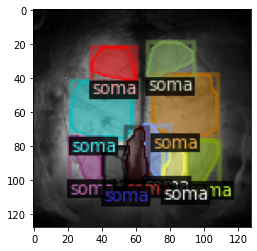

In [5]:
# plot
%matplotlib inline

for d in random.sample(mydata, 1):    
    im = cv2.imread(d["file_name"])
    
    v = Visualizer(im[:, :, ::-1],
                   metadata=mydata_metdata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

### Model configuration

In [3]:
# configuration file
cfg = configuration(num_classes=5,
                    train_output_path="C:/Users/admin/Desktop/test/out2",
                    min_image_size=125,
                    image_per_batch=1,
                    max_iter=55000, 
                    base_lr = 0.001,
                    model_weights=False, #"C:/Users/admin/Desktop/test/out/model_final.pth", # if you have another weights give that one
                    validation=True) # if you have validation turn it to True

### Model training

#### Default params

In [7]:
# start training

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[10/12 16:44:24 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

step 1: reading imageJ ROIs
Total number of ROIs are: 10
step 2: loading video in h5 format
All keys; 
         GroupHierarchy.Groups.Datasets
step 3: transfering video to images
start saving images!


100%|█████████████████████████████████████| 1400/1400 [00:03<00:00, 448.26it/s]


step 4: creating annotation dictionary
step 5: converting to COCO style dataset
start to write COCO style dataset!


100%|█████████████████████████████████████| 4003/4003 [00:12<00:00, 329.36it/s]


step 1: reading imageJ ROIs
Total number of ROIs are: 10
step 2: loading video in h5 format
All keys; 
         GroupHierarchy.Groups.Datasets
step 3: transfering video to images
start saving images!


100%|█████████████████████████████████████| 1500/1500 [00:03<00:00, 491.45it/s]


step 4: creating annotation dictionary
step 5: converting to COCO style dataset
start to write COCO style dataset!


100%|█████████████████████████████████████| 4003/4003 [00:14<00:00, 269.26it/s]

[10/12 16:45:10 d2.data.build]: Removed 0 images with no usable annotations. 8000 images left.


[10/12 16:45:10 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    soma    | 80000        |
|            |              |
[10/12 16:45:10 d2.data.common]: Serializing 8000 elements to byte tensors and concatenating them all ...
[10/12 16:45:11 d2.data.common]: Serialized dataset takes 33.11 MiB
[10/12 16:45:11 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(125,), max_size=1333, sample_style='choice'), RandomFlip()]
[10/12 16:45:11 d2.data.build]: Using training sampler TrainingSampler


roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[10/12 16:45:12 d2.engine.train_loop]: Starting training from iteration 0


c:\users\admin\detectron2-windows\detectron2\layers\wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


[10/12 16:45:26 d2.utils.events]:  eta: 1:06:56  iter: 19  total_loss: 4.601  loss_cls: 0.703  loss_box_reg: 0.286  loss_mask: 0.685  loss_rpn_cls: 2.677  loss_rpn_loc: 0.375  time: 0.2677  data_time: 0.3076  lr: 0.000020  max_mem: 850M
[10/12 16:45:31 d2.utils.events]:  eta: 1:08:18  iter: 39  total_loss: 2.534  loss_cls: 0.456  loss_box_reg: 0.504  loss_mask: 0.677  loss_rpn_cls: 0.626  loss_rpn_loc: 0.258  time: 0.2698  data_time: 0.0036  lr: 0.000040  max_mem: 875M
[10/12 16:45:37 d2.utils.events]:  eta: 1:07:24  iter: 59  total_loss: 1.949  loss_cls: 0.349  loss_box_reg: 0.366  loss_mask: 0.659  loss_rpn_cls: 0.300  loss_rpn_loc: 0.224  time: 0.2702  data_time: 0.0032  lr: 0.000060  max_mem: 875M
[10/12 16:45:43 d2.utils.events]:  eta: 1:07:23  iter: 79  total_loss: 1.846  loss_cls: 0.352  loss_box_reg: 0.394  loss_mask: 0.644  loss_rpn_cls: 0.215  loss_rpn_loc: 0.191  time: 0.2707  data_time: 0.0039  lr: 0.000080  max_mem: 875M
[10/12 16:45:48 d2.utils.events]:  eta: 1:07:53  ite

[10/12 16:48:45 d2.utils.events]:  eta: 1:10:08  iter: 699  total_loss: 0.477  loss_cls: 0.084  loss_box_reg: 0.162  loss_mask: 0.126  loss_rpn_cls: 0.014  loss_rpn_loc: 0.085  time: 0.2898  data_time: 0.0030  lr: 0.000699  max_mem: 1072M
[10/12 16:48:51 d2.utils.events]:  eta: 1:10:07  iter: 719  total_loss: 0.433  loss_cls: 0.083  loss_box_reg: 0.141  loss_mask: 0.116  loss_rpn_cls: 0.012  loss_rpn_loc: 0.085  time: 0.2901  data_time: 0.0021  lr: 0.000719  max_mem: 1072M
[10/12 16:48:57 d2.utils.events]:  eta: 1:10:06  iter: 739  total_loss: 0.397  loss_cls: 0.075  loss_box_reg: 0.135  loss_mask: 0.113  loss_rpn_cls: 0.008  loss_rpn_loc: 0.062  time: 0.2903  data_time: 0.0019  lr: 0.000739  max_mem: 1072M
[10/12 16:49:03 d2.utils.events]:  eta: 1:10:01  iter: 759  total_loss: 0.454  loss_cls: 0.073  loss_box_reg: 0.160  loss_mask: 0.112  loss_rpn_cls: 0.007  loss_rpn_loc: 0.062  time: 0.2904  data_time: 0.0025  lr: 0.000759  max_mem: 1072M
[10/12 16:49:09 d2.utils.events]:  eta: 1:09

[10/12 16:52:02 d2.utils.events]:  eta: 1:07:48  iter: 1359  total_loss: 0.242  loss_cls: 0.039  loss_box_reg: 0.074  loss_mask: 0.073  loss_rpn_cls: 0.006  loss_rpn_loc: 0.040  time: 0.2927  data_time: 0.0070  lr: 0.001000  max_mem: 1072M
[10/12 16:52:08 d2.utils.events]:  eta: 1:07:46  iter: 1379  total_loss: 0.270  loss_cls: 0.040  loss_box_reg: 0.079  loss_mask: 0.080  loss_rpn_cls: 0.006  loss_rpn_loc: 0.050  time: 0.2928  data_time: 0.0066  lr: 0.001000  max_mem: 1072M
[10/12 16:52:14 d2.utils.events]:  eta: 1:07:42  iter: 1399  total_loss: 0.234  loss_cls: 0.040  loss_box_reg: 0.075  loss_mask: 0.075  loss_rpn_cls: 0.005  loss_rpn_loc: 0.034  time: 0.2930  data_time: 0.0068  lr: 0.001000  max_mem: 1072M
[10/12 16:52:20 d2.utils.events]:  eta: 1:07:38  iter: 1419  total_loss: 0.244  loss_cls: 0.038  loss_box_reg: 0.078  loss_mask: 0.072  loss_rpn_cls: 0.005  loss_rpn_loc: 0.039  time: 0.2932  data_time: 0.0069  lr: 0.001000  max_mem: 1072M
[10/12 16:52:26 d2.utils.events]:  eta: 

[10/12 16:55:19 d2.utils.events]:  eta: 1:04:35  iter: 2019  total_loss: 0.216  loss_cls: 0.028  loss_box_reg: 0.065  loss_mask: 0.065  loss_rpn_cls: 0.004  loss_rpn_loc: 0.048  time: 0.2941  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 16:55:25 d2.utils.events]:  eta: 1:04:30  iter: 2039  total_loss: 0.205  loss_cls: 0.030  loss_box_reg: 0.066  loss_mask: 0.060  loss_rpn_cls: 0.003  loss_rpn_loc: 0.034  time: 0.2941  data_time: 0.0014  lr: 0.001000  max_mem: 1072M
[10/12 16:55:31 d2.utils.events]:  eta: 1:04:24  iter: 2059  total_loss: 0.265  loss_cls: 0.027  loss_box_reg: 0.077  loss_mask: 0.069  loss_rpn_cls: 0.004  loss_rpn_loc: 0.059  time: 0.2940  data_time: 0.0010  lr: 0.001000  max_mem: 1072M
[10/12 16:55:37 d2.utils.events]:  eta: 1:04:17  iter: 2079  total_loss: 0.220  loss_cls: 0.033  loss_box_reg: 0.065  loss_mask: 0.058  loss_rpn_cls: 0.005  loss_rpn_loc: 0.047  time: 0.2940  data_time: 0.0013  lr: 0.001000  max_mem: 1072M
[10/12 16:55:43 d2.utils.events]:  eta: 

[10/12 16:58:36 d2.utils.events]:  eta: 1:01:03  iter: 2679  total_loss: 0.263  loss_cls: 0.019  loss_box_reg: 0.053  loss_mask: 0.103  loss_rpn_cls: 0.005  loss_rpn_loc: 0.067  time: 0.2942  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 16:58:42 d2.utils.events]:  eta: 1:00:58  iter: 2699  total_loss: 0.173  loss_cls: 0.028  loss_box_reg: 0.048  loss_mask: 0.052  loss_rpn_cls: 0.003  loss_rpn_loc: 0.028  time: 0.2942  data_time: 0.0009  lr: 0.001000  max_mem: 1072M
[10/12 16:58:48 d2.utils.events]:  eta: 1:00:52  iter: 2719  total_loss: 0.180  loss_cls: 0.027  loss_box_reg: 0.053  loss_mask: 0.053  loss_rpn_cls: 0.003  loss_rpn_loc: 0.039  time: 0.2942  data_time: 0.0007  lr: 0.001000  max_mem: 1072M
[10/12 16:58:54 d2.utils.events]:  eta: 1:00:46  iter: 2739  total_loss: 0.173  loss_cls: 0.022  loss_box_reg: 0.055  loss_mask: 0.053  loss_rpn_cls: 0.004  loss_rpn_loc: 0.033  time: 0.2942  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 16:59:00 d2.utils.events]:  eta: 

[10/12 17:01:53 d2.utils.events]:  eta: 0:57:53  iter: 3339  total_loss: 0.226  loss_cls: 0.019  loss_box_reg: 0.046  loss_mask: 0.071  loss_rpn_cls: 0.006  loss_rpn_loc: 0.070  time: 0.2946  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:01:59 d2.utils.events]:  eta: 0:57:48  iter: 3359  total_loss: 0.160  loss_cls: 0.020  loss_box_reg: 0.052  loss_mask: 0.048  loss_rpn_cls: 0.004  loss_rpn_loc: 0.033  time: 0.2946  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:02:05 d2.utils.events]:  eta: 0:57:42  iter: 3379  total_loss: 0.284  loss_cls: 0.023  loss_box_reg: 0.059  loss_mask: 0.098  loss_rpn_cls: 0.008  loss_rpn_loc: 0.081  time: 0.2946  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:02:11 d2.utils.events]:  eta: 0:57:37  iter: 3399  total_loss: 0.207  loss_cls: 0.028  loss_box_reg: 0.059  loss_mask: 0.059  loss_rpn_cls: 0.004  loss_rpn_loc: 0.050  time: 0.2946  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:02:17 d2.utils.events]:  eta: 

[10/12 17:05:12 d2.utils.events]:  eta: 0:55:00  iter: 3999  total_loss: 0.127  loss_cls: 0.019  loss_box_reg: 0.042  loss_mask: 0.046  loss_rpn_cls: 0.003  loss_rpn_loc: 0.019  time: 0.2952  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:05:18 d2.utils.events]:  eta: 0:54:56  iter: 4019  total_loss: 0.132  loss_cls: 0.017  loss_box_reg: 0.040  loss_mask: 0.046  loss_rpn_cls: 0.003  loss_rpn_loc: 0.022  time: 0.2952  data_time: 0.0009  lr: 0.001000  max_mem: 1072M
[10/12 17:05:24 d2.utils.events]:  eta: 0:54:50  iter: 4039  total_loss: 0.148  loss_cls: 0.018  loss_box_reg: 0.042  loss_mask: 0.047  loss_rpn_cls: 0.003  loss_rpn_loc: 0.028  time: 0.2953  data_time: 0.0009  lr: 0.001000  max_mem: 1072M
[10/12 17:05:30 d2.utils.events]:  eta: 0:54:44  iter: 4059  total_loss: 0.170  loss_cls: 0.020  loss_box_reg: 0.045  loss_mask: 0.048  loss_rpn_cls: 0.004  loss_rpn_loc: 0.035  time: 0.2953  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:05:36 d2.utils.events]:  eta: 

[10/12 17:08:29 d2.utils.events]:  eta: 0:51:31  iter: 4659  total_loss: 0.120  loss_cls: 0.018  loss_box_reg: 0.037  loss_mask: 0.043  loss_rpn_cls: 0.002  loss_rpn_loc: 0.016  time: 0.2953  data_time: 0.0010  lr: 0.001000  max_mem: 1072M
[10/12 17:08:35 d2.utils.events]:  eta: 0:51:22  iter: 4679  total_loss: 0.149  loss_cls: 0.016  loss_box_reg: 0.038  loss_mask: 0.049  loss_rpn_cls: 0.003  loss_rpn_loc: 0.018  time: 0.2952  data_time: 0.0010  lr: 0.001000  max_mem: 1072M
[10/12 17:08:40 d2.utils.events]:  eta: 0:51:14  iter: 4699  total_loss: 0.140  loss_cls: 0.017  loss_box_reg: 0.039  loss_mask: 0.048  loss_rpn_cls: 0.003  loss_rpn_loc: 0.023  time: 0.2952  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:08:46 d2.utils.events]:  eta: 0:51:07  iter: 4719  total_loss: 0.191  loss_cls: 0.019  loss_box_reg: 0.040  loss_mask: 0.067  loss_rpn_cls: 0.004  loss_rpn_loc: 0.061  time: 0.2952  data_time: 0.0009  lr: 0.001000  max_mem: 1072M
[10/12 17:08:52 d2.utils.events]:  eta: 

[10/12 17:11:46 d2.utils.events]:  eta: 0:47:59  iter: 5319  total_loss: 0.119  loss_cls: 0.018  loss_box_reg: 0.037  loss_mask: 0.044  loss_rpn_cls: 0.003  loss_rpn_loc: 0.013  time: 0.2950  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:11:52 d2.utils.events]:  eta: 0:47:53  iter: 5339  total_loss: 0.116  loss_cls: 0.017  loss_box_reg: 0.035  loss_mask: 0.044  loss_rpn_cls: 0.002  loss_rpn_loc: 0.016  time: 0.2950  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:11:58 d2.utils.events]:  eta: 0:47:45  iter: 5359  total_loss: 0.121  loss_cls: 0.017  loss_box_reg: 0.035  loss_mask: 0.044  loss_rpn_cls: 0.002  loss_rpn_loc: 0.016  time: 0.2949  data_time: 0.0016  lr: 0.001000  max_mem: 1072M
[10/12 17:12:04 d2.utils.events]:  eta: 0:47:38  iter: 5379  total_loss: 0.121  loss_cls: 0.020  loss_box_reg: 0.034  loss_mask: 0.043  loss_rpn_cls: 0.002  loss_rpn_loc: 0.021  time: 0.2949  data_time: 0.0011  lr: 0.001000  max_mem: 1072M
[10/12 17:12:10 d2.utils.events]:  eta: 

[10/12 17:15:04 d2.utils.events]:  eta: 0:44:50  iter: 5979  total_loss: 0.129  loss_cls: 0.015  loss_box_reg: 0.037  loss_mask: 0.042  loss_rpn_cls: 0.002  loss_rpn_loc: 0.030  time: 0.2952  data_time: 0.0009  lr: 0.001000  max_mem: 1072M
[10/12 17:15:09 d2.utils.events]:  eta: 0:44:44  iter: 5999  total_loss: 0.129  loss_cls: 0.016  loss_box_reg: 0.038  loss_mask: 0.042  loss_rpn_cls: 0.002  loss_rpn_loc: 0.023  time: 0.2952  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:15:15 d2.utils.events]:  eta: 0:44:38  iter: 6019  total_loss: 0.126  loss_cls: 0.016  loss_box_reg: 0.039  loss_mask: 0.041  loss_rpn_cls: 0.002  loss_rpn_loc: 0.023  time: 0.2952  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:15:21 d2.utils.events]:  eta: 0:44:33  iter: 6039  total_loss: 0.123  loss_cls: 0.012  loss_box_reg: 0.036  loss_mask: 0.043  loss_rpn_cls: 0.002  loss_rpn_loc: 0.020  time: 0.2952  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:15:27 d2.utils.events]:  eta: 

[10/12 17:18:20 d2.utils.events]:  eta: 0:41:33  iter: 6639  total_loss: 0.131  loss_cls: 0.017  loss_box_reg: 0.036  loss_mask: 0.041  loss_rpn_cls: 0.003  loss_rpn_loc: 0.030  time: 0.2951  data_time: 0.0009  lr: 0.001000  max_mem: 1072M
[10/12 17:18:26 d2.utils.events]:  eta: 0:41:27  iter: 6659  total_loss: 0.121  loss_cls: 0.012  loss_box_reg: 0.032  loss_mask: 0.041  loss_rpn_cls: 0.003  loss_rpn_loc: 0.018  time: 0.2951  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:18:32 d2.utils.events]:  eta: 0:41:20  iter: 6679  total_loss: 0.113  loss_cls: 0.013  loss_box_reg: 0.033  loss_mask: 0.040  loss_rpn_cls: 0.002  loss_rpn_loc: 0.019  time: 0.2951  data_time: 0.0012  lr: 0.001000  max_mem: 1072M
[10/12 17:18:38 d2.utils.events]:  eta: 0:41:14  iter: 6699  total_loss: 0.116  loss_cls: 0.016  loss_box_reg: 0.034  loss_mask: 0.040  loss_rpn_cls: 0.002  loss_rpn_loc: 0.020  time: 0.2952  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:18:43 d2.utils.events]:  eta: 

[10/12 17:21:38 d2.utils.events]:  eta: 0:38:26  iter: 7299  total_loss: 0.128  loss_cls: 0.017  loss_box_reg: 0.039  loss_mask: 0.041  loss_rpn_cls: 0.002  loss_rpn_loc: 0.020  time: 0.2954  data_time: 0.0023  lr: 0.001000  max_mem: 1072M
[10/12 17:21:44 d2.utils.events]:  eta: 0:38:20  iter: 7319  total_loss: 0.137  loss_cls: 0.014  loss_box_reg: 0.034  loss_mask: 0.047  loss_rpn_cls: 0.002  loss_rpn_loc: 0.028  time: 0.2954  data_time: 0.0035  lr: 0.001000  max_mem: 1072M
[10/12 17:21:50 d2.utils.events]:  eta: 0:38:14  iter: 7339  total_loss: 0.130  loss_cls: 0.014  loss_box_reg: 0.032  loss_mask: 0.043  loss_rpn_cls: 0.003  loss_rpn_loc: 0.029  time: 0.2954  data_time: 0.0037  lr: 0.001000  max_mem: 1072M
[10/12 17:21:56 d2.utils.events]:  eta: 0:38:09  iter: 7359  total_loss: 0.135  loss_cls: 0.016  loss_box_reg: 0.042  loss_mask: 0.041  loss_rpn_cls: 0.003  loss_rpn_loc: 0.027  time: 0.2955  data_time: 0.0040  lr: 0.001000  max_mem: 1072M
[10/12 17:22:02 d2.utils.events]:  eta: 

[10/12 17:24:55 d2.utils.events]:  eta: 0:35:18  iter: 7959  total_loss: 0.146  loss_cls: 0.010  loss_box_reg: 0.031  loss_mask: 0.043  loss_rpn_cls: 0.003  loss_rpn_loc: 0.038  time: 0.2955  data_time: 0.0039  lr: 0.001000  max_mem: 1072M
[10/12 17:25:01 d2.utils.events]:  eta: 0:35:11  iter: 7979  total_loss: 0.146  loss_cls: 0.015  loss_box_reg: 0.034  loss_mask: 0.040  loss_rpn_cls: 0.003  loss_rpn_loc: 0.040  time: 0.2955  data_time: 0.0036  lr: 0.001000  max_mem: 1072M
[10/12 17:25:07 d2.utils.events]:  eta: 0:35:04  iter: 7999  total_loss: 0.101  loss_cls: 0.011  loss_box_reg: 0.025  loss_mask: 0.039  loss_rpn_cls: 0.003  loss_rpn_loc: 0.015  time: 0.2955  data_time: 0.0039  lr: 0.001000  max_mem: 1072M
[10/12 17:25:13 d2.utils.events]:  eta: 0:34:58  iter: 8019  total_loss: 0.106  loss_cls: 0.015  loss_box_reg: 0.026  loss_mask: 0.040  loss_rpn_cls: 0.002  loss_rpn_loc: 0.014  time: 0.2955  data_time: 0.0039  lr: 0.001000  max_mem: 1072M
[10/12 17:25:19 d2.utils.events]:  eta: 

[10/12 17:28:11 d2.utils.events]:  eta: 0:31:46  iter: 8619  total_loss: 0.121  loss_cls: 0.018  loss_box_reg: 0.035  loss_mask: 0.040  loss_rpn_cls: 0.002  loss_rpn_loc: 0.026  time: 0.2955  data_time: 0.0035  lr: 0.001000  max_mem: 1072M
[10/12 17:28:18 d2.utils.events]:  eta: 0:31:40  iter: 8639  total_loss: 0.108  loss_cls: 0.013  loss_box_reg: 0.031  loss_mask: 0.040  loss_rpn_cls: 0.002  loss_rpn_loc: 0.017  time: 0.2955  data_time: 0.0041  lr: 0.001000  max_mem: 1072M
[10/12 17:28:23 d2.utils.events]:  eta: 0:31:33  iter: 8659  total_loss: 0.123  loss_cls: 0.014  loss_box_reg: 0.026  loss_mask: 0.041  loss_rpn_cls: 0.003  loss_rpn_loc: 0.016  time: 0.2955  data_time: 0.0017  lr: 0.001000  max_mem: 1072M
[10/12 17:28:29 d2.utils.events]:  eta: 0:31:27  iter: 8679  total_loss: 0.106  loss_cls: 0.011  loss_box_reg: 0.028  loss_mask: 0.040  loss_rpn_cls: 0.002  loss_rpn_loc: 0.015  time: 0.2955  data_time: 0.0020  lr: 0.001000  max_mem: 1072M
[10/12 17:28:35 d2.utils.events]:  eta: 

[10/12 17:31:28 d2.utils.events]:  eta: 0:28:26  iter: 9279  total_loss: 0.116  loss_cls: 0.012  loss_box_reg: 0.036  loss_mask: 0.038  loss_rpn_cls: 0.003  loss_rpn_loc: 0.019  time: 0.2955  data_time: 0.0012  lr: 0.001000  max_mem: 1072M
[10/12 17:31:34 d2.utils.events]:  eta: 0:28:19  iter: 9299  total_loss: 0.122  loss_cls: 0.011  loss_box_reg: 0.031  loss_mask: 0.039  loss_rpn_cls: 0.003  loss_rpn_loc: 0.020  time: 0.2955  data_time: 0.0019  lr: 0.001000  max_mem: 1072M
[10/12 17:31:40 d2.utils.events]:  eta: 0:28:14  iter: 9319  total_loss: 0.127  loss_cls: 0.015  loss_box_reg: 0.041  loss_mask: 0.039  loss_rpn_cls: 0.002  loss_rpn_loc: 0.016  time: 0.2955  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:31:46 d2.utils.events]:  eta: 0:28:08  iter: 9339  total_loss: 0.117  loss_cls: 0.012  loss_box_reg: 0.030  loss_mask: 0.040  loss_rpn_cls: 0.003  loss_rpn_loc: 0.022  time: 0.2955  data_time: 0.0011  lr: 0.001000  max_mem: 1072M
[10/12 17:31:52 d2.utils.events]:  eta: 

[10/12 17:34:44 d2.utils.events]:  eta: 0:25:10  iter: 9939  total_loss: 0.119  loss_cls: 0.015  loss_box_reg: 0.033  loss_mask: 0.039  loss_rpn_cls: 0.003  loss_rpn_loc: 0.023  time: 0.2955  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:34:50 d2.utils.events]:  eta: 0:25:04  iter: 9959  total_loss: 0.131  loss_cls: 0.012  loss_box_reg: 0.028  loss_mask: 0.064  loss_rpn_cls: 0.004  loss_rpn_loc: 0.036  time: 0.2955  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:34:56 d2.utils.events]:  eta: 0:24:59  iter: 9979  total_loss: 0.109  loss_cls: 0.013  loss_box_reg: 0.029  loss_mask: 0.038  loss_rpn_cls: 0.002  loss_rpn_loc: 0.019  time: 0.2955  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:35:05 d2.utils.events]:  eta: 0:24:53  iter: 9999  total_loss: 0.101  loss_cls: 0.012  loss_box_reg: 0.024  loss_mask: 0.038  loss_rpn_cls: 0.002  loss_rpn_loc: 0.019  time: 0.2955  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:35:11 d2.utils.events]:  eta: 

[10/12 17:38:04 d2.utils.events]:  eta: 0:21:52  iter: 10599  total_loss: 0.098  loss_cls: 0.011  loss_box_reg: 0.029  loss_mask: 0.037  loss_rpn_cls: 0.002  loss_rpn_loc: 0.014  time: 0.2955  data_time: 0.0009  lr: 0.001000  max_mem: 1072M
[10/12 17:38:10 d2.utils.events]:  eta: 0:21:46  iter: 10619  total_loss: 0.091  loss_cls: 0.013  loss_box_reg: 0.025  loss_mask: 0.037  loss_rpn_cls: 0.002  loss_rpn_loc: 0.012  time: 0.2955  data_time: 0.0014  lr: 0.001000  max_mem: 1072M
[10/12 17:38:16 d2.utils.events]:  eta: 0:21:40  iter: 10639  total_loss: 0.088  loss_cls: 0.011  loss_box_reg: 0.021  loss_mask: 0.037  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.2955  data_time: 0.0013  lr: 0.001000  max_mem: 1072M
[10/12 17:38:22 d2.utils.events]:  eta: 0:21:33  iter: 10659  total_loss: 0.102  loss_cls: 0.012  loss_box_reg: 0.024  loss_mask: 0.037  loss_rpn_cls: 0.002  loss_rpn_loc: 0.020  time: 0.2955  data_time: 0.0019  lr: 0.001000  max_mem: 1072M
[10/12 17:38:28 d2.utils.events]:  e

[10/12 17:41:20 d2.utils.events]:  eta: 0:18:35  iter: 11259  total_loss: 0.093  loss_cls: 0.010  loss_box_reg: 0.026  loss_mask: 0.036  loss_rpn_cls: 0.002  loss_rpn_loc: 0.012  time: 0.2954  data_time: 0.0042  lr: 0.001000  max_mem: 1072M
[10/12 17:41:26 d2.utils.events]:  eta: 0:18:29  iter: 11279  total_loss: 0.096  loss_cls: 0.012  loss_box_reg: 0.024  loss_mask: 0.036  loss_rpn_cls: 0.002  loss_rpn_loc: 0.012  time: 0.2954  data_time: 0.0028  lr: 0.001000  max_mem: 1072M
[10/12 17:41:32 d2.utils.events]:  eta: 0:18:23  iter: 11299  total_loss: 0.088  loss_cls: 0.010  loss_box_reg: 0.023  loss_mask: 0.037  loss_rpn_cls: 0.002  loss_rpn_loc: 0.012  time: 0.2954  data_time: 0.0035  lr: 0.001000  max_mem: 1072M
[10/12 17:41:38 d2.utils.events]:  eta: 0:18:17  iter: 11319  total_loss: 0.095  loss_cls: 0.010  loss_box_reg: 0.024  loss_mask: 0.037  loss_rpn_cls: 0.001  loss_rpn_loc: 0.017  time: 0.2954  data_time: 0.0026  lr: 0.001000  max_mem: 1072M
[10/12 17:41:44 d2.utils.events]:  e

[10/12 17:44:37 d2.utils.events]:  eta: 0:15:18  iter: 11919  total_loss: 0.094  loss_cls: 0.013  loss_box_reg: 0.028  loss_mask: 0.036  loss_rpn_cls: 0.002  loss_rpn_loc: 0.014  time: 0.2954  data_time: 0.0010  lr: 0.001000  max_mem: 1072M
[10/12 17:44:43 d2.utils.events]:  eta: 0:15:12  iter: 11939  total_loss: 0.092  loss_cls: 0.012  loss_box_reg: 0.027  loss_mask: 0.036  loss_rpn_cls: 0.001  loss_rpn_loc: 0.012  time: 0.2954  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:44:49 d2.utils.events]:  eta: 0:15:07  iter: 11959  total_loss: 0.112  loss_cls: 0.011  loss_box_reg: 0.025  loss_mask: 0.039  loss_rpn_cls: 0.001  loss_rpn_loc: 0.026  time: 0.2954  data_time: 0.0008  lr: 0.001000  max_mem: 1072M
[10/12 17:44:55 d2.utils.events]:  eta: 0:15:01  iter: 11979  total_loss: 0.110  loss_cls: 0.014  loss_box_reg: 0.027  loss_mask: 0.037  loss_rpn_cls: 0.002  loss_rpn_loc: 0.023  time: 0.2954  data_time: 0.0012  lr: 0.001000  max_mem: 1072M
[10/12 17:45:01 d2.utils.events]:  e

[10/12 17:47:53 d2.utils.events]:  eta: 0:12:01  iter: 12579  total_loss: 0.090  loss_cls: 0.012  loss_box_reg: 0.025  loss_mask: 0.036  loss_rpn_cls: 0.002  loss_rpn_loc: 0.014  time: 0.2954  data_time: 0.0020  lr: 0.001000  max_mem: 1072M
[10/12 17:47:59 d2.utils.events]:  eta: 0:11:55  iter: 12599  total_loss: 0.099  loss_cls: 0.008  loss_box_reg: 0.022  loss_mask: 0.046  loss_rpn_cls: 0.002  loss_rpn_loc: 0.021  time: 0.2954  data_time: 0.0019  lr: 0.001000  max_mem: 1072M
[10/12 17:48:05 d2.utils.events]:  eta: 0:11:49  iter: 12619  total_loss: 0.089  loss_cls: 0.011  loss_box_reg: 0.024  loss_mask: 0.035  loss_rpn_cls: 0.002  loss_rpn_loc: 0.013  time: 0.2954  data_time: 0.0031  lr: 0.001000  max_mem: 1072M
[10/12 17:48:11 d2.utils.events]:  eta: 0:11:43  iter: 12639  total_loss: 0.106  loss_cls: 0.012  loss_box_reg: 0.025  loss_mask: 0.036  loss_rpn_cls: 0.002  loss_rpn_loc: 0.021  time: 0.2954  data_time: 0.0027  lr: 0.001000  max_mem: 1072M
[10/12 17:48:16 d2.utils.events]:  e

[10/12 17:51:09 d2.utils.events]:  eta: 0:08:43  iter: 13239  total_loss: 0.092  loss_cls: 0.011  loss_box_reg: 0.025  loss_mask: 0.035  loss_rpn_cls: 0.001  loss_rpn_loc: 0.015  time: 0.2953  data_time: 0.0034  lr: 0.001000  max_mem: 1072M
[10/12 17:51:14 d2.utils.events]:  eta: 0:08:37  iter: 13259  total_loss: 0.090  loss_cls: 0.008  loss_box_reg: 0.021  loss_mask: 0.035  loss_rpn_cls: 0.002  loss_rpn_loc: 0.016  time: 0.2953  data_time: 0.0025  lr: 0.001000  max_mem: 1072M
[10/12 17:51:20 d2.utils.events]:  eta: 0:08:30  iter: 13279  total_loss: 0.103  loss_cls: 0.010  loss_box_reg: 0.026  loss_mask: 0.036  loss_rpn_cls: 0.002  loss_rpn_loc: 0.020  time: 0.2953  data_time: 0.0020  lr: 0.001000  max_mem: 1072M
[10/12 17:51:26 d2.utils.events]:  eta: 0:08:24  iter: 13299  total_loss: 0.102  loss_cls: 0.010  loss_box_reg: 0.032  loss_mask: 0.034  loss_rpn_cls: 0.002  loss_rpn_loc: 0.013  time: 0.2953  data_time: 0.0028  lr: 0.001000  max_mem: 1072M
[10/12 17:51:32 d2.utils.events]:  e

[10/12 17:54:37 d2.utils.events]:  eta: 0:05:29  iter: 13899  total_loss: 0.096  loss_cls: 0.008  loss_box_reg: 0.026  loss_mask: 0.035  loss_rpn_cls: 0.001  loss_rpn_loc: 0.016  time: 0.2955  data_time: 0.0066  lr: 0.001000  max_mem: 1072M
[10/12 17:54:43 d2.utils.events]:  eta: 0:05:23  iter: 13919  total_loss: 0.101  loss_cls: 0.009  loss_box_reg: 0.028  loss_mask: 0.034  loss_rpn_cls: 0.002  loss_rpn_loc: 0.017  time: 0.2955  data_time: 0.0069  lr: 0.001000  max_mem: 1072M
[10/12 17:54:49 d2.utils.events]:  eta: 0:05:17  iter: 13939  total_loss: 0.108  loss_cls: 0.009  loss_box_reg: 0.029  loss_mask: 0.035  loss_rpn_cls: 0.002  loss_rpn_loc: 0.020  time: 0.2955  data_time: 0.0069  lr: 0.001000  max_mem: 1072M
[10/12 17:54:56 d2.utils.events]:  eta: 0:05:11  iter: 13959  total_loss: 0.111  loss_cls: 0.008  loss_box_reg: 0.030  loss_mask: 0.035  loss_rpn_cls: 0.003  loss_rpn_loc: 0.018  time: 0.2955  data_time: 0.0066  lr: 0.001000  max_mem: 1072M
[10/12 17:55:02 d2.utils.events]:  e

[10/12 17:58:23 d2.utils.events]:  eta: 0:02:14  iter: 14559  total_loss: 0.099  loss_cls: 0.010  loss_box_reg: 0.026  loss_mask: 0.033  loss_rpn_cls: 0.002  loss_rpn_loc: 0.019  time: 0.2957  data_time: 0.0057  lr: 0.001000  max_mem: 1072M
[10/12 17:58:30 d2.utils.events]:  eta: 0:02:08  iter: 14579  total_loss: 0.074  loss_cls: 0.007  loss_box_reg: 0.020  loss_mask: 0.033  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.2957  data_time: 0.0056  lr: 0.001000  max_mem: 1072M
[10/12 17:58:36 d2.utils.events]:  eta: 0:02:02  iter: 14599  total_loss: 0.079  loss_cls: 0.009  loss_box_reg: 0.023  loss_mask: 0.034  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.2958  data_time: 0.0057  lr: 0.001000  max_mem: 1072M
[10/12 17:58:43 d2.utils.events]:  eta: 0:01:56  iter: 14619  total_loss: 0.099  loss_cls: 0.005  loss_box_reg: 0.020  loss_mask: 0.036  loss_rpn_cls: 0.002  loss_rpn_loc: 0.017  time: 0.2958  data_time: 0.0058  lr: 0.001000  max_mem: 1072M
[10/12 17:58:49 d2.utils.events]:  e

100%|███████████████████████████████████████| 800/800 [00:01<00:00, 535.44it/s]


step 4: creating annotation dictionary
step 5: converting to COCO style dataset
start to write COCO style dataset!


100%|█████████████████████████████████████| 4003/4003 [00:08<00:00, 498.97it/s]


step 1: reading imageJ ROIs
Total number of ROIs are: 10
step 2: loading video in h5 format
All keys; 
         GroupHierarchy.Groups.Datasets
step 3: transfering video to images
start saving images!


100%|███████████████████████████████████████| 800/800 [00:01<00:00, 581.36it/s]


step 4: creating annotation dictionary
step 5: converting to COCO style dataset
start to write COCO style dataset!


100%|█████████████████████████████████████| 4003/4003 [00:06<00:00, 597.61it/s]


[10/12 18:01:19 d2.data.common]: Serializing 8000 elements to byte tensors and concatenating them all ...
[10/12 18:01:19 d2.data.common]: Serialized dataset takes 33.11 MiB
[10/12 18:01:19 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(125,), max_size=1333, sample_style='choice')]
WARNING [10/12 18:01:19 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[10/12 18:01:19 d2.utils.events]:  eta: 0:00:00  iter: 14999  total_loss: 0.098  loss_cls: 0.010  loss_box_reg: 0.021  loss_mask: 0.035  loss_rpn_cls: 0.002  loss_rpn_loc: 0.017  time: 0.2958  data_time: 0.0045  lr: 0.001000  max_mem: 1072M
[10/12 18:01:19 d2.engine.hooks]: Overall training speed: 14997 iterations in 1:13:57 (0.2959 s / it)
[10/12 18:01:19 d2.engine.hooks]: Total training time: 1:15:58 (0:02:01 on hooks)


#### Custom data loader (with data augmentation)

In [6]:
class CustomTrainer(DefaultTrainer):
    
    # trainer
    @classmethod
    def build_train_loader(cls, cfg):
        dataloader = build_detection_train_loader(cfg,
           mapper=DatasetMapper(cfg, is_train=True, augmentations=[
               T.Resize((800, 800)),
               T.Resize((100, 100)),
               T.RandomBrightness(intensity_min=0.1, intensity_max=4), 
               T.Resize((200, 200)),
               T.RandomBrightness(intensity_min=0.5, intensity_max=2), 
               T.RandomContrast(intensity_min=0.5, intensity_max=2), 
               T.RandomCrop(crop_type="relative", crop_size=(0.8, 0.8)), 
               T.RandomFlip(),
               T.RandomFlip(vertical=True, horizontal=False)
               ]))
        return dataloader
    
    #evaluator
    #@classmethod
    #def build_evaluator(cls, cfg):
    #    return COCOEvaluator("val", cfg, True, os.path.join(cfg.OUTPUT_DIR,"inference"))

In [7]:
# https://www.kaggle.com/dhiiyaur/detectron-2-compare-models-augmentation
#https://ortegatron.medium.com/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
# first time install shapely

trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[10/25 18:19:44 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[10/25 18:19:44 d2.data.dataset_mapper]: Augmentations used in training: [Resize(shape=(800, 800)), Resize(shape=(100, 100)), RandomBrightness(intensity_min=0.1, intensity_max=4), Resize(shape=(200, 200)), RandomBrightness(intensity_min=0.5, intensity_max=2), RandomContrast(intensity_min=0.5, intensity_max=2), RandomCrop(crop_type='relative', crop_size=(0.8, 0.8)), RandomFlip(), RandomFlip(horizontal=False, vertical=True)]
[10/25 18:21:23 d2.data.datasets.coco]: Loading I:/Sina/Medical report segmentation/publaynet/train.json takes 99.05 seconds.
[10/25 18:21:25 d2.data.datasets.coco]: Loaded 335703 images in COCO format from I:/Sina/Medical report segmentation/publaynet/train.json
[10/25 18:21:55 d2.data.build]: Removed 0 images with no usable annotations. 335703 images left.
[10/25 18:22:11 d2.data.build]: Distribution of instances among all 5 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (5, 256, 1, 1) 

[10/25 18:22:41 d2.engine.train_loop]: Starting training from iteration 0


c:\users\admin\detectron2-windows\detectron2\layers\wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


[10/25 18:23:12 d2.utils.events]:  eta: 3:59:07  iter: 19  total_loss: 7.896  loss_cls: 1.805  loss_box_reg: 0.239  loss_mask: 0.697  loss_rpn_cls: 4.473  loss_rpn_loc: 0.742  time: 0.2659  data_time: 1.1918  lr: 0.000020  max_mem: 1082M
[10/25 18:23:18 d2.utils.events]:  eta: 4:01:50  iter: 39  total_loss: 3.394  loss_cls: 0.771  loss_box_reg: 0.195  loss_mask: 0.683  loss_rpn_cls: 0.805  loss_rpn_loc: 0.799  time: 0.2677  data_time: 0.0007  lr: 0.000040  max_mem: 1082M
[10/25 18:23:23 d2.utils.events]:  eta: 4:04:33  iter: 59  total_loss: 2.563  loss_cls: 0.501  loss_box_reg: 0.360  loss_mask: 0.664  loss_rpn_cls: 0.458  loss_rpn_loc: 0.647  time: 0.2696  data_time: 0.0007  lr: 0.000060  max_mem: 1082M
[10/25 18:23:29 d2.utils.events]:  eta: 4:06:38  iter: 79  total_loss: 2.403  loss_cls: 0.485  loss_box_reg: 0.401  loss_mask: 0.626  loss_rpn_cls: 0.360  loss_rpn_loc: 0.696  time: 0.2724  data_time: 0.0007  lr: 0.000080  max_mem: 1155M
[10/25 18:23:34 d2.utils.events]:  eta: 4:06:32 

[10/25 18:25:55 d2.utils.events]:  eta: 4:11:16  iter: 579  total_loss: 2.263  loss_cls: 0.452  loss_box_reg: 0.492  loss_mask: 0.429  loss_rpn_cls: 0.384  loss_rpn_loc: 0.541  time: 0.2798  data_time: 0.0007  lr: 0.000579  max_mem: 1257M
[10/25 18:26:01 d2.utils.events]:  eta: 4:11:08  iter: 599  total_loss: 2.299  loss_cls: 0.428  loss_box_reg: 0.393  loss_mask: 0.429  loss_rpn_cls: 0.384  loss_rpn_loc: 0.520  time: 0.2799  data_time: 0.0007  lr: 0.000599  max_mem: 1257M
[10/25 18:26:06 d2.utils.events]:  eta: 4:11:06  iter: 619  total_loss: 2.004  loss_cls: 0.370  loss_box_reg: 0.399  loss_mask: 0.411  loss_rpn_cls: 0.309  loss_rpn_loc: 0.307  time: 0.2801  data_time: 0.0007  lr: 0.000619  max_mem: 1257M
[10/25 18:26:12 d2.utils.events]:  eta: 4:11:38  iter: 639  total_loss: 2.300  loss_cls: 0.437  loss_box_reg: 0.493  loss_mask: 0.439  loss_rpn_cls: 0.328  loss_rpn_loc: 0.602  time: 0.2802  data_time: 0.0007  lr: 0.000639  max_mem: 1257M
[10/25 18:26:18 d2.utils.events]:  eta: 4:11

[10/25 18:28:51 d2.utils.events]:  eta: 4:12:11  iter: 1179  total_loss: 2.105  loss_cls: 0.409  loss_box_reg: 0.396  loss_mask: 0.422  loss_rpn_cls: 0.343  loss_rpn_loc: 0.537  time: 0.2822  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 18:28:57 d2.utils.events]:  eta: 4:12:16  iter: 1199  total_loss: 2.154  loss_cls: 0.360  loss_box_reg: 0.449  loss_mask: 0.449  loss_rpn_cls: 0.297  loss_rpn_loc: 0.447  time: 0.2823  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 18:29:03 d2.utils.events]:  eta: 4:12:13  iter: 1219  total_loss: 2.160  loss_cls: 0.406  loss_box_reg: 0.473  loss_mask: 0.416  loss_rpn_cls: 0.326  loss_rpn_loc: 0.558  time: 0.2823  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 18:29:09 d2.utils.events]:  eta: 4:12:14  iter: 1239  total_loss: 2.076  loss_cls: 0.364  loss_box_reg: 0.430  loss_mask: 0.404  loss_rpn_cls: 0.350  loss_rpn_loc: 0.397  time: 0.2824  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 18:29:14 d2.utils.events]:  eta: 

[10/25 18:31:51 d2.utils.events]:  eta: 4:12:52  iter: 1779  total_loss: 2.107  loss_cls: 0.346  loss_box_reg: 0.327  loss_mask: 0.407  loss_rpn_cls: 0.362  loss_rpn_loc: 0.679  time: 0.2845  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 18:31:57 d2.utils.events]:  eta: 4:12:44  iter: 1799  total_loss: 2.018  loss_cls: 0.368  loss_box_reg: 0.390  loss_mask: 0.423  loss_rpn_cls: 0.363  loss_rpn_loc: 0.406  time: 0.2845  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 18:32:03 d2.utils.events]:  eta: 4:12:43  iter: 1819  total_loss: 2.040  loss_cls: 0.366  loss_box_reg: 0.319  loss_mask: 0.428  loss_rpn_cls: 0.301  loss_rpn_loc: 0.571  time: 0.2845  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 18:32:09 d2.utils.events]:  eta: 4:12:48  iter: 1839  total_loss: 1.872  loss_cls: 0.405  loss_box_reg: 0.398  loss_mask: 0.433  loss_rpn_cls: 0.341  loss_rpn_loc: 0.420  time: 0.2846  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 18:32:14 d2.utils.events]:  eta: 

[10/25 18:34:49 d2.utils.events]:  eta: 4:09:47  iter: 2379  total_loss: 1.954  loss_cls: 0.392  loss_box_reg: 0.410  loss_mask: 0.434  loss_rpn_cls: 0.335  loss_rpn_loc: 0.378  time: 0.2845  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 18:34:55 d2.utils.events]:  eta: 4:09:24  iter: 2399  total_loss: 1.538  loss_cls: 0.286  loss_box_reg: 0.276  loss_mask: 0.343  loss_rpn_cls: 0.303  loss_rpn_loc: 0.252  time: 0.2845  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 18:35:00 d2.utils.events]:  eta: 4:09:09  iter: 2419  total_loss: 2.173  loss_cls: 0.409  loss_box_reg: 0.389  loss_mask: 0.423  loss_rpn_cls: 0.348  loss_rpn_loc: 0.595  time: 0.2845  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 18:35:06 d2.utils.events]:  eta: 4:08:44  iter: 2439  total_loss: 1.887  loss_cls: 0.294  loss_box_reg: 0.276  loss_mask: 0.426  loss_rpn_cls: 0.322  loss_rpn_loc: 0.492  time: 0.2845  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 18:35:12 d2.utils.events]:  eta: 

[10/25 18:37:47 d2.utils.events]:  eta: 4:04:35  iter: 2979  total_loss: 2.150  loss_cls: 0.411  loss_box_reg: 0.422  loss_mask: 0.442  loss_rpn_cls: 0.327  loss_rpn_loc: 0.418  time: 0.2845  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 18:37:56 d2.data.datasets.coco]: Loading I:/Sina/Medical report segmentation/publaynet/val.json takes 3.26 seconds.
[10/25 18:37:56 d2.data.datasets.coco]: Loaded 11245 images in COCO format from I:/Sina/Medical report segmentation/publaynet/val.json
[10/25 18:37:57 d2.data.common]: Serializing 11245 elements to byte tensors and concatenating them all ...
[10/25 18:37:58 d2.data.common]: Serialized dataset takes 55.68 MiB
[10/25 18:37:58 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(125, 125), max_size=1333, sample_style='choice')]
WARNING [10/25 18:37:58 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[10/25 18:37:58 d

[10/25 18:40:34 d2.utils.events]:  eta: 4:03:12  iter: 3519  total_loss: 2.095  loss_cls: 0.370  loss_box_reg: 0.397  loss_mask: 0.442  loss_rpn_cls: 0.321  loss_rpn_loc: 0.480  time: 0.2848  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 18:40:40 d2.utils.events]:  eta: 4:03:11  iter: 3539  total_loss: 1.982  loss_cls: 0.355  loss_box_reg: 0.295  loss_mask: 0.431  loss_rpn_cls: 0.311  loss_rpn_loc: 0.440  time: 0.2848  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 18:40:46 d2.utils.events]:  eta: 4:03:06  iter: 3559  total_loss: 2.125  loss_cls: 0.368  loss_box_reg: 0.415  loss_mask: 0.437  loss_rpn_cls: 0.350  loss_rpn_loc: 0.584  time: 0.2847  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 18:40:51 d2.utils.events]:  eta: 4:03:01  iter: 3579  total_loss: 1.884  loss_cls: 0.361  loss_box_reg: 0.325  loss_mask: 0.419  loss_rpn_cls: 0.327  loss_rpn_loc: 0.366  time: 0.2847  data_time: 0.0009  lr: 0.001000  max_mem: 1257M
[10/25 18:40:57 d2.utils.events]:  eta: 

[10/25 18:43:32 d2.utils.events]:  eta: 4:01:29  iter: 4119  total_loss: 2.068  loss_cls: 0.434  loss_box_reg: 0.476  loss_mask: 0.440  loss_rpn_cls: 0.322  loss_rpn_loc: 0.400  time: 0.2849  data_time: 0.0010  lr: 0.001000  max_mem: 1257M
[10/25 18:43:38 d2.utils.events]:  eta: 4:01:18  iter: 4139  total_loss: 1.970  loss_cls: 0.368  loss_box_reg: 0.297  loss_mask: 0.399  loss_rpn_cls: 0.309  loss_rpn_loc: 0.522  time: 0.2849  data_time: 0.0010  lr: 0.001000  max_mem: 1257M
[10/25 18:43:44 d2.utils.events]:  eta: 4:01:12  iter: 4159  total_loss: 1.903  loss_cls: 0.339  loss_box_reg: 0.337  loss_mask: 0.397  loss_rpn_cls: 0.323  loss_rpn_loc: 0.557  time: 0.2849  data_time: 0.0009  lr: 0.001000  max_mem: 1257M
[10/25 18:43:49 d2.utils.events]:  eta: 4:01:05  iter: 4179  total_loss: 1.558  loss_cls: 0.261  loss_box_reg: 0.331  loss_mask: 0.390  loss_rpn_cls: 0.294  loss_rpn_loc: 0.330  time: 0.2849  data_time: 0.0010  lr: 0.001000  max_mem: 1257M
[10/25 18:43:55 d2.utils.events]:  eta: 

[10/25 18:46:30 d2.utils.events]:  eta: 3:57:37  iter: 4719  total_loss: 1.900  loss_cls: 0.335  loss_box_reg: 0.326  loss_mask: 0.424  loss_rpn_cls: 0.322  loss_rpn_loc: 0.422  time: 0.2850  data_time: 0.0041  lr: 0.001000  max_mem: 1257M
[10/25 18:46:36 d2.utils.events]:  eta: 3:57:26  iter: 4739  total_loss: 2.093  loss_cls: 0.384  loss_box_reg: 0.389  loss_mask: 0.411  loss_rpn_cls: 0.362  loss_rpn_loc: 0.368  time: 0.2850  data_time: 0.0042  lr: 0.001000  max_mem: 1257M
[10/25 18:46:42 d2.utils.events]:  eta: 3:57:31  iter: 4759  total_loss: 2.070  loss_cls: 0.414  loss_box_reg: 0.401  loss_mask: 0.431  loss_rpn_cls: 0.374  loss_rpn_loc: 0.566  time: 0.2850  data_time: 0.0047  lr: 0.001000  max_mem: 1257M
[10/25 18:46:48 d2.utils.events]:  eta: 3:57:26  iter: 4779  total_loss: 2.105  loss_cls: 0.363  loss_box_reg: 0.375  loss_mask: 0.447  loss_rpn_cls: 0.356  loss_rpn_loc: 0.587  time: 0.2850  data_time: 0.0040  lr: 0.001000  max_mem: 1257M
[10/25 18:46:54 d2.utils.events]:  eta: 

[10/25 18:49:33 d2.utils.events]:  eta: 3:56:34  iter: 5319  total_loss: 1.788  loss_cls: 0.296  loss_box_reg: 0.294  loss_mask: 0.385  loss_rpn_cls: 0.326  loss_rpn_loc: 0.420  time: 0.2854  data_time: 0.0043  lr: 0.001000  max_mem: 1257M
[10/25 18:49:39 d2.utils.events]:  eta: 3:56:35  iter: 5339  total_loss: 1.919  loss_cls: 0.314  loss_box_reg: 0.342  loss_mask: 0.383  loss_rpn_cls: 0.368  loss_rpn_loc: 0.499  time: 0.2854  data_time: 0.0046  lr: 0.001000  max_mem: 1257M
[10/25 18:49:44 d2.utils.events]:  eta: 3:56:34  iter: 5359  total_loss: 2.046  loss_cls: 0.363  loss_box_reg: 0.307  loss_mask: 0.434  loss_rpn_cls: 0.377  loss_rpn_loc: 0.559  time: 0.2854  data_time: 0.0040  lr: 0.001000  max_mem: 1257M
[10/25 18:49:50 d2.utils.events]:  eta: 3:56:20  iter: 5379  total_loss: 2.051  loss_cls: 0.361  loss_box_reg: 0.397  loss_mask: 0.428  loss_rpn_cls: 0.350  loss_rpn_loc: 0.540  time: 0.2854  data_time: 0.0027  lr: 0.001000  max_mem: 1257M
[10/25 18:49:56 d2.utils.events]:  eta: 

[10/25 18:52:31 d2.utils.events]:  eta: 3:53:21  iter: 5919  total_loss: 2.065  loss_cls: 0.355  loss_box_reg: 0.337  loss_mask: 0.423  loss_rpn_cls: 0.368  loss_rpn_loc: 0.407  time: 0.2855  data_time: 0.0006  lr: 0.001000  max_mem: 1257M
[10/25 18:52:37 d2.utils.events]:  eta: 3:53:25  iter: 5939  total_loss: 1.860  loss_cls: 0.349  loss_box_reg: 0.335  loss_mask: 0.399  loss_rpn_cls: 0.334  loss_rpn_loc: 0.372  time: 0.2855  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 18:52:43 d2.utils.events]:  eta: 3:53:06  iter: 5959  total_loss: 1.947  loss_cls: 0.345  loss_box_reg: 0.339  loss_mask: 0.409  loss_rpn_cls: 0.338  loss_rpn_loc: 0.430  time: 0.2855  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 18:52:49 d2.utils.events]:  eta: 3:53:02  iter: 5979  total_loss: 1.646  loss_cls: 0.280  loss_box_reg: 0.312  loss_mask: 0.372  loss_rpn_cls: 0.302  loss_rpn_loc: 0.335  time: 0.2855  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 18:52:58 d2.data.datasets.coco]: 

[10/25 18:55:28 d2.data.common]: Serializing 11245 elements to byte tensors and concatenating them all ...
[10/25 18:55:29 d2.data.common]: Serialized dataset takes 55.68 MiB
[10/25 18:55:29 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(125, 125), max_size=1333, sample_style='choice')]
WARNING [10/25 18:55:29 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[10/25 18:55:29 d2.utils.events]:  eta: 3:49:02  iter: 6499  total_loss: 2.133  loss_cls: 0.339  loss_box_reg: 0.345  loss_mask: 0.437  loss_rpn_cls: 0.343  loss_rpn_loc: 0.483  time: 0.2854  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 18:55:35 d2.utils.events]:  eta: 3:48:59  iter: 6519  total_loss: 1.768  loss_cls: 0.335  loss_box_reg: 0.324  loss_mask: 0.403  loss_rpn_cls: 0.295  loss_rpn_loc: 0.372  time: 0.2854  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 18:55:40 d2.utils.events]:  

[10/25 18:58:16 d2.utils.events]:  eta: 3:45:46  iter: 7059  total_loss: 1.993  loss_cls: 0.353  loss_box_reg: 0.313  loss_mask: 0.408  loss_rpn_cls: 0.331  loss_rpn_loc: 0.412  time: 0.2855  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 18:58:22 d2.utils.events]:  eta: 3:45:41  iter: 7079  total_loss: 1.881  loss_cls: 0.348  loss_box_reg: 0.318  loss_mask: 0.403  loss_rpn_cls: 0.327  loss_rpn_loc: 0.435  time: 0.2855  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 18:58:28 d2.utils.events]:  eta: 3:45:34  iter: 7099  total_loss: 1.896  loss_cls: 0.316  loss_box_reg: 0.324  loss_mask: 0.412  loss_rpn_cls: 0.345  loss_rpn_loc: 0.331  time: 0.2855  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 18:58:33 d2.utils.events]:  eta: 3:45:28  iter: 7119  total_loss: 1.882  loss_cls: 0.346  loss_box_reg: 0.324  loss_mask: 0.379  loss_rpn_cls: 0.284  loss_rpn_loc: 0.537  time: 0.2855  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 18:58:39 d2.utils.events]:  eta: 

[10/25 19:01:15 d2.utils.events]:  eta: 3:43:35  iter: 7659  total_loss: 1.802  loss_cls: 0.318  loss_box_reg: 0.320  loss_mask: 0.405  loss_rpn_cls: 0.299  loss_rpn_loc: 0.352  time: 0.2855  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 19:01:21 d2.utils.events]:  eta: 3:43:24  iter: 7679  total_loss: 1.725  loss_cls: 0.292  loss_box_reg: 0.303  loss_mask: 0.407  loss_rpn_cls: 0.325  loss_rpn_loc: 0.405  time: 0.2855  data_time: 0.0009  lr: 0.001000  max_mem: 1257M
[10/25 19:01:27 d2.utils.events]:  eta: 3:43:18  iter: 7699  total_loss: 1.849  loss_cls: 0.273  loss_box_reg: 0.295  loss_mask: 0.399  loss_rpn_cls: 0.299  loss_rpn_loc: 0.378  time: 0.2855  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 19:01:32 d2.utils.events]:  eta: 3:43:04  iter: 7719  total_loss: 2.235  loss_cls: 0.451  loss_box_reg: 0.454  loss_mask: 0.448  loss_rpn_cls: 0.351  loss_rpn_loc: 0.416  time: 0.2855  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:01:38 d2.utils.events]:  eta: 

[10/25 19:04:15 d2.utils.events]:  eta: 3:42:32  iter: 8259  total_loss: 1.995  loss_cls: 0.339  loss_box_reg: 0.357  loss_mask: 0.433  loss_rpn_cls: 0.341  loss_rpn_loc: 0.399  time: 0.2856  data_time: 0.0009  lr: 0.001000  max_mem: 1257M
[10/25 19:04:21 d2.utils.events]:  eta: 3:42:27  iter: 8279  total_loss: 1.809  loss_cls: 0.328  loss_box_reg: 0.368  loss_mask: 0.421  loss_rpn_cls: 0.352  loss_rpn_loc: 0.310  time: 0.2856  data_time: 0.0009  lr: 0.001000  max_mem: 1257M
[10/25 19:04:27 d2.utils.events]:  eta: 3:42:43  iter: 8299  total_loss: 1.781  loss_cls: 0.359  loss_box_reg: 0.331  loss_mask: 0.438  loss_rpn_cls: 0.311  loss_rpn_loc: 0.268  time: 0.2857  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 19:04:32 d2.utils.events]:  eta: 3:42:31  iter: 8319  total_loss: 1.875  loss_cls: 0.331  loss_box_reg: 0.345  loss_mask: 0.413  loss_rpn_cls: 0.318  loss_rpn_loc: 0.401  time: 0.2857  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:04:38 d2.utils.events]:  eta: 

[10/25 19:07:15 d2.utils.events]:  eta: 3:40:08  iter: 8859  total_loss: 2.039  loss_cls: 0.345  loss_box_reg: 0.315  loss_mask: 0.410  loss_rpn_cls: 0.315  loss_rpn_loc: 0.479  time: 0.2858  data_time: 0.0010  lr: 0.001000  max_mem: 1257M
[10/25 19:07:21 d2.utils.events]:  eta: 3:40:00  iter: 8879  total_loss: 2.074  loss_cls: 0.375  loss_box_reg: 0.390  loss_mask: 0.407  loss_rpn_cls: 0.318  loss_rpn_loc: 0.406  time: 0.2858  data_time: 0.0006  lr: 0.001000  max_mem: 1257M
[10/25 19:07:26 d2.utils.events]:  eta: 3:40:03  iter: 8899  total_loss: 2.004  loss_cls: 0.315  loss_box_reg: 0.410  loss_mask: 0.390  loss_rpn_cls: 0.312  loss_rpn_loc: 0.529  time: 0.2858  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:07:32 d2.utils.events]:  eta: 3:39:54  iter: 8919  total_loss: 1.712  loss_cls: 0.334  loss_box_reg: 0.381  loss_mask: 0.347  loss_rpn_cls: 0.307  loss_rpn_loc: 0.289  time: 0.2858  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:07:38 d2.utils.events]:  eta: 

[10/25 19:10:14 d2.utils.events]:  eta: 3:36:55  iter: 9459  total_loss: 2.113  loss_cls: 0.423  loss_box_reg: 0.401  loss_mask: 0.439  loss_rpn_cls: 0.320  loss_rpn_loc: 0.364  time: 0.2859  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 19:10:20 d2.utils.events]:  eta: 3:36:51  iter: 9479  total_loss: 2.017  loss_cls: 0.310  loss_box_reg: 0.336  loss_mask: 0.403  loss_rpn_cls: 0.329  loss_rpn_loc: 0.434  time: 0.2859  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 19:10:29 d2.data.datasets.coco]: Loading I:/Sina/Medical report segmentation/publaynet/val.json takes 3.40 seconds.
[10/25 19:10:29 d2.data.datasets.coco]: Loaded 11245 images in COCO format from I:/Sina/Medical report segmentation/publaynet/val.json
[10/25 19:10:31 d2.data.common]: Serializing 11245 elements to byte tensors and concatenating them all ...
[10/25 19:10:31 d2.data.common]: Serialized dataset takes 55.68 MiB
[10/25 19:10:31 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortes

[10/25 19:13:05 d2.utils.events]:  eta: 3:33:59  iter: 9999  total_loss: 2.114  loss_cls: 0.372  loss_box_reg: 0.360  loss_mask: 0.427  loss_rpn_cls: 0.323  loss_rpn_loc: 0.540  time: 0.2859  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:13:11 d2.utils.events]:  eta: 3:33:55  iter: 10019  total_loss: 1.961  loss_cls: 0.350  loss_box_reg: 0.383  loss_mask: 0.417  loss_rpn_cls: 0.322  loss_rpn_loc: 0.401  time: 0.2859  data_time: 0.0009  lr: 0.001000  max_mem: 1257M
[10/25 19:13:17 d2.utils.events]:  eta: 3:33:50  iter: 10039  total_loss: 2.016  loss_cls: 0.353  loss_box_reg: 0.316  loss_mask: 0.426  loss_rpn_cls: 0.335  loss_rpn_loc: 0.398  time: 0.2859  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 19:13:23 d2.utils.events]:  eta: 3:33:50  iter: 10059  total_loss: 2.097  loss_cls: 0.383  loss_box_reg: 0.482  loss_mask: 0.407  loss_rpn_cls: 0.352  loss_rpn_loc: 0.560  time: 0.2860  data_time: 0.0010  lr: 0.001000  max_mem: 1257M
[10/25 19:13:28 d2.utils.events]:  et

[10/25 19:16:05 d2.utils.events]:  eta: 3:32:01  iter: 10599  total_loss: 1.764  loss_cls: 0.307  loss_box_reg: 0.297  loss_mask: 0.416  loss_rpn_cls: 0.329  loss_rpn_loc: 0.440  time: 0.2860  data_time: 0.0037  lr: 0.001000  max_mem: 1257M
[10/25 19:16:11 d2.utils.events]:  eta: 3:31:54  iter: 10619  total_loss: 2.169  loss_cls: 0.322  loss_box_reg: 0.303  loss_mask: 0.412  loss_rpn_cls: 0.359  loss_rpn_loc: 0.540  time: 0.2860  data_time: 0.0033  lr: 0.001000  max_mem: 1257M
[10/25 19:16:17 d2.utils.events]:  eta: 3:31:55  iter: 10639  total_loss: 1.740  loss_cls: 0.337  loss_box_reg: 0.384  loss_mask: 0.393  loss_rpn_cls: 0.298  loss_rpn_loc: 0.325  time: 0.2861  data_time: 0.0057  lr: 0.001000  max_mem: 1257M
[10/25 19:16:22 d2.utils.events]:  eta: 3:31:51  iter: 10659  total_loss: 2.209  loss_cls: 0.326  loss_box_reg: 0.295  loss_mask: 0.399  loss_rpn_cls: 0.341  loss_rpn_loc: 0.478  time: 0.2861  data_time: 0.0065  lr: 0.001000  max_mem: 1257M
[10/25 19:16:28 d2.utils.events]:  e

[10/25 19:19:07 d2.utils.events]:  eta: 3:30:25  iter: 11199  total_loss: 1.758  loss_cls: 0.347  loss_box_reg: 0.402  loss_mask: 0.406  loss_rpn_cls: 0.327  loss_rpn_loc: 0.239  time: 0.2863  data_time: 0.0011  lr: 0.001000  max_mem: 1257M
[10/25 19:19:13 d2.utils.events]:  eta: 3:30:16  iter: 11219  total_loss: 2.347  loss_cls: 0.399  loss_box_reg: 0.434  loss_mask: 0.417  loss_rpn_cls: 0.347  loss_rpn_loc: 0.520  time: 0.2863  data_time: 0.0009  lr: 0.001000  max_mem: 1257M
[10/25 19:19:18 d2.utils.events]:  eta: 3:30:02  iter: 11239  total_loss: 2.055  loss_cls: 0.338  loss_box_reg: 0.335  loss_mask: 0.424  loss_rpn_cls: 0.324  loss_rpn_loc: 0.362  time: 0.2863  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 19:19:24 d2.utils.events]:  eta: 3:29:49  iter: 11259  total_loss: 2.039  loss_cls: 0.413  loss_box_reg: 0.411  loss_mask: 0.389  loss_rpn_cls: 0.289  loss_rpn_loc: 0.418  time: 0.2863  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 19:19:30 d2.utils.events]:  e

[10/25 19:22:08 d2.utils.events]:  eta: 3:27:48  iter: 11799  total_loss: 1.948  loss_cls: 0.354  loss_box_reg: 0.306  loss_mask: 0.426  loss_rpn_cls: 0.311  loss_rpn_loc: 0.462  time: 0.2865  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:22:13 d2.utils.events]:  eta: 3:27:27  iter: 11819  total_loss: 1.733  loss_cls: 0.302  loss_box_reg: 0.334  loss_mask: 0.399  loss_rpn_cls: 0.343  loss_rpn_loc: 0.406  time: 0.2865  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:22:19 d2.utils.events]:  eta: 3:27:18  iter: 11839  total_loss: 1.963  loss_cls: 0.364  loss_box_reg: 0.346  loss_mask: 0.429  loss_rpn_cls: 0.351  loss_rpn_loc: 0.447  time: 0.2865  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 19:22:25 d2.utils.events]:  eta: 3:26:59  iter: 11859  total_loss: 1.686  loss_cls: 0.303  loss_box_reg: 0.292  loss_mask: 0.345  loss_rpn_cls: 0.284  loss_rpn_loc: 0.439  time: 0.2865  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:22:31 d2.utils.events]:  e

[10/25 19:25:07 d2.utils.events]:  eta: 3:23:32  iter: 12399  total_loss: 1.910  loss_cls: 0.340  loss_box_reg: 0.290  loss_mask: 0.405  loss_rpn_cls: 0.358  loss_rpn_loc: 0.470  time: 0.2865  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:25:13 d2.utils.events]:  eta: 3:23:22  iter: 12419  total_loss: 1.743  loss_cls: 0.290  loss_box_reg: 0.289  loss_mask: 0.390  loss_rpn_cls: 0.283  loss_rpn_loc: 0.392  time: 0.2865  data_time: 0.0010  lr: 0.001000  max_mem: 1257M
[10/25 19:25:18 d2.utils.events]:  eta: 3:23:17  iter: 12439  total_loss: 2.281  loss_cls: 0.364  loss_box_reg: 0.436  loss_mask: 0.442  loss_rpn_cls: 0.372  loss_rpn_loc: 0.519  time: 0.2865  data_time: 0.0011  lr: 0.001000  max_mem: 1257M
[10/25 19:25:24 d2.utils.events]:  eta: 3:23:08  iter: 12459  total_loss: 2.116  loss_cls: 0.328  loss_box_reg: 0.308  loss_mask: 0.419  loss_rpn_cls: 0.339  loss_rpn_loc: 0.312  time: 0.2865  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:25:30 d2.utils.events]:  e

[10/25 19:28:08 d2.data.datasets.coco]: Loading I:/Sina/Medical report segmentation/publaynet/val.json takes 3.21 seconds.
[10/25 19:28:08 d2.data.datasets.coco]: Loaded 11245 images in COCO format from I:/Sina/Medical report segmentation/publaynet/val.json
[10/25 19:28:10 d2.data.common]: Serializing 11245 elements to byte tensors and concatenating them all ...
[10/25 19:28:11 d2.data.common]: Serialized dataset takes 55.68 MiB
[10/25 19:28:11 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(125, 125), max_size=1333, sample_style='choice')]
WARNING [10/25 19:28:11 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[10/25 19:28:11 d2.utils.events]:  eta: 3:19:40  iter: 12999  total_loss: 1.998  loss_cls: 0.322  loss_box_reg: 0.339  loss_mask: 0.438  loss_rpn_cls: 0.318  loss_rpn_loc: 0.507  time: 0.2865  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:28:17 

[10/25 19:30:53 d2.utils.events]:  eta: 3:17:22  iter: 13539  total_loss: 1.930  loss_cls: 0.360  loss_box_reg: 0.335  loss_mask: 0.422  loss_rpn_cls: 0.306  loss_rpn_loc: 0.475  time: 0.2865  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:30:59 d2.utils.events]:  eta: 3:17:20  iter: 13559  total_loss: 1.796  loss_cls: 0.307  loss_box_reg: 0.328  loss_mask: 0.415  loss_rpn_cls: 0.329  loss_rpn_loc: 0.332  time: 0.2865  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 19:31:05 d2.utils.events]:  eta: 3:17:14  iter: 13579  total_loss: 2.199  loss_cls: 0.385  loss_box_reg: 0.405  loss_mask: 0.419  loss_rpn_cls: 0.355  loss_rpn_loc: 0.497  time: 0.2865  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 19:31:10 d2.utils.events]:  eta: 3:17:01  iter: 13599  total_loss: 1.824  loss_cls: 0.305  loss_box_reg: 0.354  loss_mask: 0.404  loss_rpn_cls: 0.315  loss_rpn_loc: 0.233  time: 0.2865  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:31:16 d2.utils.events]:  e

[10/25 19:33:53 d2.utils.events]:  eta: 3:14:39  iter: 14139  total_loss: 1.905  loss_cls: 0.327  loss_box_reg: 0.326  loss_mask: 0.423  loss_rpn_cls: 0.347  loss_rpn_loc: 0.401  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:33:58 d2.utils.events]:  eta: 3:14:28  iter: 14159  total_loss: 1.998  loss_cls: 0.279  loss_box_reg: 0.286  loss_mask: 0.432  loss_rpn_cls: 0.357  loss_rpn_loc: 0.517  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:34:04 d2.utils.events]:  eta: 3:14:14  iter: 14179  total_loss: 2.087  loss_cls: 0.386  loss_box_reg: 0.412  loss_mask: 0.448  loss_rpn_cls: 0.309  loss_rpn_loc: 0.475  time: 0.2866  data_time: 0.0009  lr: 0.001000  max_mem: 1257M
[10/25 19:34:10 d2.utils.events]:  eta: 3:14:08  iter: 14199  total_loss: 1.921  loss_cls: 0.335  loss_box_reg: 0.352  loss_mask: 0.424  loss_rpn_cls: 0.330  loss_rpn_loc: 0.407  time: 0.2865  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:34:16 d2.utils.events]:  e

[10/25 19:36:52 d2.utils.events]:  eta: 3:11:16  iter: 14739  total_loss: 1.538  loss_cls: 0.311  loss_box_reg: 0.279  loss_mask: 0.360  loss_rpn_cls: 0.278  loss_rpn_loc: 0.478  time: 0.2866  data_time: 0.0009  lr: 0.001000  max_mem: 1257M
[10/25 19:36:57 d2.utils.events]:  eta: 3:11:12  iter: 14759  total_loss: 2.012  loss_cls: 0.404  loss_box_reg: 0.377  loss_mask: 0.410  loss_rpn_cls: 0.326  loss_rpn_loc: 0.462  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:37:03 d2.utils.events]:  eta: 3:10:59  iter: 14779  total_loss: 2.174  loss_cls: 0.383  loss_box_reg: 0.371  loss_mask: 0.421  loss_rpn_cls: 0.348  loss_rpn_loc: 0.509  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:37:09 d2.utils.events]:  eta: 3:10:54  iter: 14799  total_loss: 2.089  loss_cls: 0.388  loss_box_reg: 0.403  loss_mask: 0.410  loss_rpn_cls: 0.334  loss_rpn_loc: 0.426  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:37:15 d2.utils.events]:  e

[10/25 19:39:53 d2.utils.events]:  eta: 3:08:20  iter: 15339  total_loss: 2.154  loss_cls: 0.358  loss_box_reg: 0.335  loss_mask: 0.439  loss_rpn_cls: 0.353  loss_rpn_loc: 0.529  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:39:59 d2.utils.events]:  eta: 3:08:15  iter: 15359  total_loss: 1.941  loss_cls: 0.327  loss_box_reg: 0.390  loss_mask: 0.404  loss_rpn_cls: 0.311  loss_rpn_loc: 0.427  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:40:05 d2.utils.events]:  eta: 3:08:12  iter: 15379  total_loss: 1.854  loss_cls: 0.329  loss_box_reg: 0.357  loss_mask: 0.393  loss_rpn_cls: 0.309  loss_rpn_loc: 0.362  time: 0.2866  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 19:40:11 d2.utils.events]:  eta: 3:08:04  iter: 15399  total_loss: 1.690  loss_cls: 0.332  loss_box_reg: 0.299  loss_mask: 0.413  loss_rpn_cls: 0.296  loss_rpn_loc: 0.254  time: 0.2866  data_time: 0.0006  lr: 0.001000  max_mem: 1257M
[10/25 19:40:16 d2.utils.events]:  e

[10/25 19:42:52 d2.utils.events]:  eta: 3:05:31  iter: 15939  total_loss: 1.964  loss_cls: 0.365  loss_box_reg: 0.327  loss_mask: 0.404  loss_rpn_cls: 0.281  loss_rpn_loc: 0.449  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:42:58 d2.utils.events]:  eta: 3:05:14  iter: 15959  total_loss: 1.885  loss_cls: 0.341  loss_box_reg: 0.272  loss_mask: 0.421  loss_rpn_cls: 0.308  loss_rpn_loc: 0.533  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:43:04 d2.utils.events]:  eta: 3:05:14  iter: 15979  total_loss: 1.981  loss_cls: 0.359  loss_box_reg: 0.347  loss_mask: 0.391  loss_rpn_cls: 0.305  loss_rpn_loc: 0.509  time: 0.2866  data_time: 0.0006  lr: 0.001000  max_mem: 1257M
[10/25 19:43:13 d2.data.datasets.coco]: Loading I:/Sina/Medical report segmentation/publaynet/val.json takes 3.50 seconds.
[10/25 19:43:13 d2.data.datasets.coco]: Loaded 11245 images in COCO format from I:/Sina/Medical report segmentation/publaynet/val.json
[10/25 19:43:14 d2.

[10/25 19:45:45 d2.data.common]: Serialized dataset takes 55.68 MiB
[10/25 19:45:45 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(125, 125), max_size=1333, sample_style='choice')]
WARNING [10/25 19:45:45 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[10/25 19:45:46 d2.utils.events]:  eta: 3:02:42  iter: 16499  total_loss: 1.815  loss_cls: 0.327  loss_box_reg: 0.345  loss_mask: 0.415  loss_rpn_cls: 0.320  loss_rpn_loc: 0.281  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:45:51 d2.utils.events]:  eta: 3:02:36  iter: 16519  total_loss: 1.984  loss_cls: 0.365  loss_box_reg: 0.388  loss_mask: 0.411  loss_rpn_cls: 0.332  loss_rpn_loc: 0.350  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:45:57 d2.utils.events]:  eta: 3:02:18  iter: 16539  total_loss: 1.985  loss_cls: 0.355  loss_box_reg: 0.366  loss_mask: 0.401  los

[10/25 19:48:33 d2.utils.events]:  eta: 3:00:27  iter: 17059  total_loss: 1.589  loss_cls: 0.240  loss_box_reg: 0.239  loss_mask: 0.419  loss_rpn_cls: 0.281  loss_rpn_loc: 0.369  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:48:39 d2.utils.events]:  eta: 3:00:31  iter: 17079  total_loss: 1.804  loss_cls: 0.362  loss_box_reg: 0.364  loss_mask: 0.405  loss_rpn_cls: 0.349  loss_rpn_loc: 0.294  time: 0.2866  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 19:48:45 d2.utils.events]:  eta: 3:00:26  iter: 17099  total_loss: 2.311  loss_cls: 0.395  loss_box_reg: 0.422  loss_mask: 0.421  loss_rpn_cls: 0.327  loss_rpn_loc: 0.513  time: 0.2866  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 19:48:50 d2.utils.events]:  eta: 3:00:12  iter: 17119  total_loss: 1.817  loss_cls: 0.297  loss_box_reg: 0.264  loss_mask: 0.428  loss_rpn_cls: 0.303  loss_rpn_loc: 0.442  time: 0.2866  data_time: 0.0006  lr: 0.001000  max_mem: 1257M
[10/25 19:48:56 d2.utils.events]:  e

[10/25 19:51:31 d2.utils.events]:  eta: 2:56:36  iter: 17659  total_loss: 1.657  loss_cls: 0.277  loss_box_reg: 0.311  loss_mask: 0.411  loss_rpn_cls: 0.316  loss_rpn_loc: 0.380  time: 0.2865  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:51:37 d2.utils.events]:  eta: 2:56:31  iter: 17679  total_loss: 1.981  loss_cls: 0.320  loss_box_reg: 0.254  loss_mask: 0.421  loss_rpn_cls: 0.323  loss_rpn_loc: 0.404  time: 0.2865  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:51:43 d2.utils.events]:  eta: 2:56:24  iter: 17699  total_loss: 1.928  loss_cls: 0.380  loss_box_reg: 0.418  loss_mask: 0.410  loss_rpn_cls: 0.334  loss_rpn_loc: 0.464  time: 0.2865  data_time: 0.0009  lr: 0.001000  max_mem: 1257M
[10/25 19:51:48 d2.utils.events]:  eta: 2:56:20  iter: 17719  total_loss: 1.994  loss_cls: 0.389  loss_box_reg: 0.344  loss_mask: 0.411  loss_rpn_cls: 0.323  loss_rpn_loc: 0.390  time: 0.2865  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:51:54 d2.utils.events]:  e

[10/25 19:54:30 d2.utils.events]:  eta: 2:54:42  iter: 18259  total_loss: 1.787  loss_cls: 0.329  loss_box_reg: 0.331  loss_mask: 0.368  loss_rpn_cls: 0.302  loss_rpn_loc: 0.364  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:54:36 d2.utils.events]:  eta: 2:54:36  iter: 18279  total_loss: 1.827  loss_cls: 0.346  loss_box_reg: 0.319  loss_mask: 0.395  loss_rpn_cls: 0.325  loss_rpn_loc: 0.395  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:54:42 d2.utils.events]:  eta: 2:54:30  iter: 18299  total_loss: 1.976  loss_cls: 0.370  loss_box_reg: 0.358  loss_mask: 0.394  loss_rpn_cls: 0.313  loss_rpn_loc: 0.560  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:54:48 d2.utils.events]:  eta: 2:54:10  iter: 18319  total_loss: 2.063  loss_cls: 0.345  loss_box_reg: 0.311  loss_mask: 0.429  loss_rpn_cls: 0.309  loss_rpn_loc: 0.619  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:54:53 d2.utils.events]:  e

[10/25 19:57:30 d2.utils.events]:  eta: 2:52:21  iter: 18859  total_loss: 2.108  loss_cls: 0.406  loss_box_reg: 0.448  loss_mask: 0.421  loss_rpn_cls: 0.334  loss_rpn_loc: 0.456  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:57:36 d2.utils.events]:  eta: 2:52:15  iter: 18879  total_loss: 2.023  loss_cls: 0.346  loss_box_reg: 0.299  loss_mask: 0.414  loss_rpn_cls: 0.346  loss_rpn_loc: 0.530  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:57:42 d2.utils.events]:  eta: 2:52:09  iter: 18899  total_loss: 2.003  loss_cls: 0.344  loss_box_reg: 0.357  loss_mask: 0.419  loss_rpn_cls: 0.339  loss_rpn_loc: 0.420  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:57:48 d2.utils.events]:  eta: 2:52:02  iter: 18919  total_loss: 1.739  loss_cls: 0.268  loss_box_reg: 0.242  loss_mask: 0.382  loss_rpn_cls: 0.238  loss_rpn_loc: 0.475  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 19:57:53 d2.utils.events]:  e

[10/25 20:00:29 d2.utils.events]:  eta: 2:49:28  iter: 19459  total_loss: 1.902  loss_cls: 0.327  loss_box_reg: 0.321  loss_mask: 0.422  loss_rpn_cls: 0.332  loss_rpn_loc: 0.381  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:00:35 d2.utils.events]:  eta: 2:49:20  iter: 19479  total_loss: 1.861  loss_cls: 0.343  loss_box_reg: 0.316  loss_mask: 0.422  loss_rpn_cls: 0.332  loss_rpn_loc: 0.382  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:00:44 d2.data.datasets.coco]: Loading I:/Sina/Medical report segmentation/publaynet/val.json takes 3.28 seconds.
[10/25 20:00:44 d2.data.datasets.coco]: Loaded 11245 images in COCO format from I:/Sina/Medical report segmentation/publaynet/val.json
[10/25 20:00:46 d2.data.common]: Serializing 11245 elements to byte tensors and concatenating them all ...
[10/25 20:00:46 d2.data.common]: Serialized dataset takes 55.68 MiB
[10/25 20:00:46 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShort

WARNING [10/25 20:03:19 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[10/25 20:03:19 d2.utils.events]:  eta: 2:46:11  iter: 19999  total_loss: 1.980  loss_cls: 0.363  loss_box_reg: 0.367  loss_mask: 0.409  loss_rpn_cls: 0.291  loss_rpn_loc: 0.337  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:03:25 d2.utils.events]:  eta: 2:46:03  iter: 20019  total_loss: 2.084  loss_cls: 0.361  loss_box_reg: 0.310  loss_mask: 0.413  loss_rpn_cls: 0.308  loss_rpn_loc: 0.487  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:03:30 d2.utils.events]:  eta: 2:45:56  iter: 20039  total_loss: 2.043  loss_cls: 0.339  loss_box_reg: 0.366  loss_mask: 0.407  loss_rpn_cls: 0.340  loss_rpn_loc: 0.498  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:03:36 d2.utils.events]:  eta: 2:45:53  iter: 20059  total_loss: 1.724  loss_cls: 0.296  loss_box_reg: 0.279  loss_mask:

[10/25 20:06:13 d2.utils.events]:  eta: 2:43:46  iter: 20579  total_loss: 2.021  loss_cls: 0.364  loss_box_reg: 0.397  loss_mask: 0.433  loss_rpn_cls: 0.304  loss_rpn_loc: 0.369  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:06:19 d2.utils.events]:  eta: 2:43:54  iter: 20599  total_loss: 2.036  loss_cls: 0.383  loss_box_reg: 0.427  loss_mask: 0.392  loss_rpn_cls: 0.313  loss_rpn_loc: 0.483  time: 0.2866  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 20:06:25 d2.utils.events]:  eta: 2:43:47  iter: 20619  total_loss: 2.084  loss_cls: 0.358  loss_box_reg: 0.382  loss_mask: 0.416  loss_rpn_cls: 0.292  loss_rpn_loc: 0.394  time: 0.2866  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 20:06:30 d2.utils.events]:  eta: 2:43:44  iter: 20639  total_loss: 2.012  loss_cls: 0.349  loss_box_reg: 0.371  loss_mask: 0.404  loss_rpn_cls: 0.344  loss_rpn_loc: 0.477  time: 0.2866  data_time: 0.0014  lr: 0.001000  max_mem: 1257M
[10/25 20:06:36 d2.utils.events]:  e

[10/25 20:09:13 d2.utils.events]:  eta: 2:41:39  iter: 21179  total_loss: 1.805  loss_cls: 0.300  loss_box_reg: 0.316  loss_mask: 0.401  loss_rpn_cls: 0.336  loss_rpn_loc: 0.406  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:09:18 d2.utils.events]:  eta: 2:41:35  iter: 21199  total_loss: 2.019  loss_cls: 0.339  loss_box_reg: 0.375  loss_mask: 0.411  loss_rpn_cls: 0.306  loss_rpn_loc: 0.384  time: 0.2866  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 20:09:24 d2.utils.events]:  eta: 2:41:35  iter: 21219  total_loss: 1.814  loss_cls: 0.368  loss_box_reg: 0.385  loss_mask: 0.424  loss_rpn_cls: 0.341  loss_rpn_loc: 0.336  time: 0.2866  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 20:09:30 d2.utils.events]:  eta: 2:41:22  iter: 21239  total_loss: 1.990  loss_cls: 0.305  loss_box_reg: 0.251  loss_mask: 0.436  loss_rpn_cls: 0.359  loss_rpn_loc: 0.519  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:09:36 d2.utils.events]:  e

[10/25 20:12:12 d2.utils.events]:  eta: 2:37:41  iter: 21779  total_loss: 2.060  loss_cls: 0.381  loss_box_reg: 0.464  loss_mask: 0.423  loss_rpn_cls: 0.357  loss_rpn_loc: 0.401  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:12:17 d2.utils.events]:  eta: 2:37:40  iter: 21799  total_loss: 2.158  loss_cls: 0.444  loss_box_reg: 0.489  loss_mask: 0.429  loss_rpn_cls: 0.322  loss_rpn_loc: 0.432  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:12:23 d2.utils.events]:  eta: 2:37:35  iter: 21819  total_loss: 1.969  loss_cls: 0.380  loss_box_reg: 0.361  loss_mask: 0.401  loss_rpn_cls: 0.358  loss_rpn_loc: 0.381  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:12:29 d2.utils.events]:  eta: 2:37:33  iter: 21839  total_loss: 2.049  loss_cls: 0.371  loss_box_reg: 0.395  loss_mask: 0.428  loss_rpn_cls: 0.318  loss_rpn_loc: 0.467  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:12:35 d2.utils.events]:  e

[10/25 20:15:12 d2.utils.events]:  eta: 2:35:44  iter: 22379  total_loss: 2.146  loss_cls: 0.321  loss_box_reg: 0.355  loss_mask: 0.415  loss_rpn_cls: 0.353  loss_rpn_loc: 0.426  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:15:17 d2.utils.events]:  eta: 2:35:34  iter: 22399  total_loss: 1.805  loss_cls: 0.303  loss_box_reg: 0.372  loss_mask: 0.378  loss_rpn_cls: 0.327  loss_rpn_loc: 0.307  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:15:23 d2.utils.events]:  eta: 2:35:28  iter: 22419  total_loss: 1.939  loss_cls: 0.319  loss_box_reg: 0.342  loss_mask: 0.401  loss_rpn_cls: 0.300  loss_rpn_loc: 0.461  time: 0.2866  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 20:15:29 d2.utils.events]:  eta: 2:35:34  iter: 22439  total_loss: 1.991  loss_cls: 0.353  loss_box_reg: 0.355  loss_mask: 0.403  loss_rpn_cls: 0.310  loss_rpn_loc: 0.464  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:15:34 d2.utils.events]:  e

[10/25 20:18:10 d2.utils.events]:  eta: 2:32:49  iter: 22979  total_loss: 2.126  loss_cls: 0.426  loss_box_reg: 0.455  loss_mask: 0.419  loss_rpn_cls: 0.343  loss_rpn_loc: 0.357  time: 0.2866  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:18:20 d2.data.datasets.coco]: Loading I:/Sina/Medical report segmentation/publaynet/val.json takes 3.48 seconds.
[10/25 20:18:20 d2.data.datasets.coco]: Loaded 11245 images in COCO format from I:/Sina/Medical report segmentation/publaynet/val.json
[10/25 20:18:21 d2.data.common]: Serializing 11245 elements to byte tensors and concatenating them all ...
[10/25 20:18:22 d2.data.common]: Serialized dataset takes 55.68 MiB
[10/25 20:18:22 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(125, 125), max_size=1333, sample_style='choice')]
WARNING [10/25 20:18:22 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[10/25 20:18:22 

[10/25 20:20:58 d2.utils.events]:  eta: 2:30:33  iter: 23519  total_loss: 1.974  loss_cls: 0.386  loss_box_reg: 0.388  loss_mask: 0.420  loss_rpn_cls: 0.300  loss_rpn_loc: 0.389  time: 0.2867  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:21:04 d2.utils.events]:  eta: 2:30:28  iter: 23539  total_loss: 2.131  loss_cls: 0.428  loss_box_reg: 0.417  loss_mask: 0.424  loss_rpn_cls: 0.364  loss_rpn_loc: 0.443  time: 0.2867  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:21:10 d2.utils.events]:  eta: 2:30:27  iter: 23559  total_loss: 2.010  loss_cls: 0.346  loss_box_reg: 0.375  loss_mask: 0.393  loss_rpn_cls: 0.322  loss_rpn_loc: 0.413  time: 0.2867  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:21:16 d2.utils.events]:  eta: 2:30:21  iter: 23579  total_loss: 1.745  loss_cls: 0.362  loss_box_reg: 0.360  loss_mask: 0.402  loss_rpn_cls: 0.285  loss_rpn_loc: 0.300  time: 0.2867  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:21:22 d2.utils.events]:  e

[10/25 20:23:58 d2.utils.events]:  eta: 2:27:31  iter: 24119  total_loss: 2.006  loss_cls: 0.403  loss_box_reg: 0.438  loss_mask: 0.411  loss_rpn_cls: 0.311  loss_rpn_loc: 0.384  time: 0.2867  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:24:04 d2.utils.events]:  eta: 2:27:23  iter: 24139  total_loss: 1.777  loss_cls: 0.327  loss_box_reg: 0.272  loss_mask: 0.411  loss_rpn_cls: 0.360  loss_rpn_loc: 0.444  time: 0.2867  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:24:10 d2.utils.events]:  eta: 2:27:23  iter: 24159  total_loss: 2.020  loss_cls: 0.292  loss_box_reg: 0.320  loss_mask: 0.430  loss_rpn_cls: 0.327  loss_rpn_loc: 0.443  time: 0.2867  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 20:24:15 d2.utils.events]:  eta: 2:27:11  iter: 24179  total_loss: 1.744  loss_cls: 0.304  loss_box_reg: 0.277  loss_mask: 0.406  loss_rpn_cls: 0.321  loss_rpn_loc: 0.488  time: 0.2867  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:24:21 d2.utils.events]:  e

[10/25 20:26:58 d2.utils.events]:  eta: 2:24:24  iter: 24719  total_loss: 1.879  loss_cls: 0.281  loss_box_reg: 0.236  loss_mask: 0.392  loss_rpn_cls: 0.318  loss_rpn_loc: 0.380  time: 0.2867  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:27:03 d2.utils.events]:  eta: 2:24:15  iter: 24739  total_loss: 2.190  loss_cls: 0.410  loss_box_reg: 0.425  loss_mask: 0.431  loss_rpn_cls: 0.348  loss_rpn_loc: 0.453  time: 0.2867  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:27:09 d2.utils.events]:  eta: 2:24:04  iter: 24759  total_loss: 1.929  loss_cls: 0.295  loss_box_reg: 0.299  loss_mask: 0.410  loss_rpn_cls: 0.324  loss_rpn_loc: 0.567  time: 0.2867  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:27:15 d2.utils.events]:  eta: 2:23:56  iter: 24779  total_loss: 2.111  loss_cls: 0.344  loss_box_reg: 0.398  loss_mask: 0.441  loss_rpn_cls: 0.321  loss_rpn_loc: 0.430  time: 0.2867  data_time: 0.0006  lr: 0.001000  max_mem: 1257M
[10/25 20:27:21 d2.utils.events]:  e

[10/25 20:30:01 d2.utils.events]:  eta: 2:21:59  iter: 25319  total_loss: 2.149  loss_cls: 0.357  loss_box_reg: 0.365  loss_mask: 0.427  loss_rpn_cls: 0.346  loss_rpn_loc: 0.608  time: 0.2868  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 20:30:07 d2.utils.events]:  eta: 2:21:57  iter: 25339  total_loss: 2.030  loss_cls: 0.338  loss_box_reg: 0.360  loss_mask: 0.411  loss_rpn_cls: 0.336  loss_rpn_loc: 0.384  time: 0.2868  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:30:13 d2.utils.events]:  eta: 2:21:43  iter: 25359  total_loss: 1.854  loss_cls: 0.294  loss_box_reg: 0.327  loss_mask: 0.412  loss_rpn_cls: 0.298  loss_rpn_loc: 0.455  time: 0.2868  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:30:19 d2.utils.events]:  eta: 2:21:34  iter: 25379  total_loss: 2.098  loss_cls: 0.339  loss_box_reg: 0.358  loss_mask: 0.430  loss_rpn_cls: 0.351  loss_rpn_loc: 0.457  time: 0.2868  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 20:30:24 d2.utils.events]:  e

[10/25 20:33:01 d2.utils.events]:  eta: 2:19:18  iter: 25919  total_loss: 2.139  loss_cls: 0.403  loss_box_reg: 0.446  loss_mask: 0.437  loss_rpn_cls: 0.353  loss_rpn_loc: 0.547  time: 0.2868  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 20:33:06 d2.utils.events]:  eta: 2:19:05  iter: 25939  total_loss: 1.686  loss_cls: 0.295  loss_box_reg: 0.285  loss_mask: 0.388  loss_rpn_cls: 0.281  loss_rpn_loc: 0.441  time: 0.2868  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 20:33:12 d2.utils.events]:  eta: 2:19:01  iter: 25959  total_loss: 2.074  loss_cls: 0.378  loss_box_reg: 0.385  loss_mask: 0.416  loss_rpn_cls: 0.304  loss_rpn_loc: 0.467  time: 0.2868  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:33:18 d2.utils.events]:  eta: 2:18:59  iter: 25979  total_loss: 1.869  loss_cls: 0.335  loss_box_reg: 0.308  loss_mask: 0.383  loss_rpn_cls: 0.333  loss_rpn_loc: 0.434  time: 0.2868  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:33:28 d2.data.datasets.coc

[10/25 20:36:01 d2.data.common]: Serializing 11245 elements to byte tensors and concatenating them all ...
[10/25 20:36:02 d2.data.common]: Serialized dataset takes 55.68 MiB
[10/25 20:36:02 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(125, 125), max_size=1333, sample_style='choice')]
WARNING [10/25 20:36:02 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[10/25 20:36:02 d2.utils.events]:  eta: 2:16:32  iter: 26499  total_loss: 1.800  loss_cls: 0.353  loss_box_reg: 0.337  loss_mask: 0.423  loss_rpn_cls: 0.300  loss_rpn_loc: 0.297  time: 0.2868  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:36:08 d2.utils.events]:  eta: 2:16:25  iter: 26519  total_loss: 1.910  loss_cls: 0.306  loss_box_reg: 0.320  loss_mask: 0.403  loss_rpn_cls: 0.321  loss_rpn_loc: 0.446  time: 0.2868  data_time: 0.0009  lr: 0.001000  max_mem: 1257M
[10/25 20:36:14 d2.utils.events]:

[10/25 20:38:53 d2.utils.events]:  eta: 2:15:17  iter: 27059  total_loss: 1.732  loss_cls: 0.350  loss_box_reg: 0.340  loss_mask: 0.392  loss_rpn_cls: 0.332  loss_rpn_loc: 0.345  time: 0.2870  data_time: 0.0064  lr: 0.001000  max_mem: 1257M
[10/25 20:38:59 d2.utils.events]:  eta: 2:15:12  iter: 27079  total_loss: 1.802  loss_cls: 0.330  loss_box_reg: 0.346  loss_mask: 0.420  loss_rpn_cls: 0.303  loss_rpn_loc: 0.303  time: 0.2870  data_time: 0.0061  lr: 0.001000  max_mem: 1257M
[10/25 20:39:05 d2.utils.events]:  eta: 2:15:20  iter: 27099  total_loss: 2.054  loss_cls: 0.396  loss_box_reg: 0.397  loss_mask: 0.426  loss_rpn_cls: 0.315  loss_rpn_loc: 0.390  time: 0.2870  data_time: 0.0061  lr: 0.001000  max_mem: 1257M
[10/25 20:39:11 d2.utils.events]:  eta: 2:15:16  iter: 27119  total_loss: 1.891  loss_cls: 0.383  loss_box_reg: 0.366  loss_mask: 0.421  loss_rpn_cls: 0.315  loss_rpn_loc: 0.373  time: 0.2870  data_time: 0.0066  lr: 0.001000  max_mem: 1257M
[10/25 20:39:17 d2.utils.events]:  e

[10/25 20:41:54 d2.utils.events]:  eta: 2:12:34  iter: 27659  total_loss: 1.910  loss_cls: 0.336  loss_box_reg: 0.358  loss_mask: 0.394  loss_rpn_cls: 0.318  loss_rpn_loc: 0.339  time: 0.2870  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 20:42:00 d2.utils.events]:  eta: 2:12:24  iter: 27679  total_loss: 1.824  loss_cls: 0.377  loss_box_reg: 0.347  loss_mask: 0.396  loss_rpn_cls: 0.340  loss_rpn_loc: 0.344  time: 0.2870  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 20:42:06 d2.utils.events]:  eta: 2:12:18  iter: 27699  total_loss: 2.101  loss_cls: 0.405  loss_box_reg: 0.380  loss_mask: 0.419  loss_rpn_cls: 0.302  loss_rpn_loc: 0.411  time: 0.2871  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:42:12 d2.utils.events]:  eta: 2:12:04  iter: 27719  total_loss: 1.870  loss_cls: 0.323  loss_box_reg: 0.222  loss_mask: 0.411  loss_rpn_cls: 0.317  loss_rpn_loc: 0.474  time: 0.2871  data_time: 0.0006  lr: 0.001000  max_mem: 1257M
[10/25 20:42:18 d2.utils.events]:  e

[10/25 20:44:54 d2.utils.events]:  eta: 2:07:43  iter: 28259  total_loss: 2.037  loss_cls: 0.401  loss_box_reg: 0.392  loss_mask: 0.408  loss_rpn_cls: 0.329  loss_rpn_loc: 0.411  time: 0.2871  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:45:00 d2.utils.events]:  eta: 2:07:39  iter: 28279  total_loss: 2.000  loss_cls: 0.356  loss_box_reg: 0.382  loss_mask: 0.407  loss_rpn_cls: 0.346  loss_rpn_loc: 0.294  time: 0.2871  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:45:05 d2.utils.events]:  eta: 2:07:32  iter: 28299  total_loss: 1.988  loss_cls: 0.365  loss_box_reg: 0.392  loss_mask: 0.415  loss_rpn_cls: 0.338  loss_rpn_loc: 0.459  time: 0.2871  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:45:11 d2.utils.events]:  eta: 2:07:27  iter: 28319  total_loss: 1.966  loss_cls: 0.336  loss_box_reg: 0.367  loss_mask: 0.405  loss_rpn_cls: 0.331  loss_rpn_loc: 0.464  time: 0.2871  data_time: 0.0010  lr: 0.001000  max_mem: 1257M
[10/25 20:45:17 d2.utils.events]:  e

[10/25 20:47:54 d2.utils.events]:  eta: 2:04:55  iter: 28859  total_loss: 1.979  loss_cls: 0.338  loss_box_reg: 0.272  loss_mask: 0.404  loss_rpn_cls: 0.321  loss_rpn_loc: 0.432  time: 0.2871  data_time: 0.0006  lr: 0.001000  max_mem: 1257M
[10/25 20:48:00 d2.utils.events]:  eta: 2:04:51  iter: 28879  total_loss: 2.004  loss_cls: 0.409  loss_box_reg: 0.421  loss_mask: 0.422  loss_rpn_cls: 0.322  loss_rpn_loc: 0.484  time: 0.2871  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:48:06 d2.utils.events]:  eta: 2:04:46  iter: 28899  total_loss: 1.946  loss_cls: 0.355  loss_box_reg: 0.337  loss_mask: 0.419  loss_rpn_cls: 0.324  loss_rpn_loc: 0.432  time: 0.2871  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:48:12 d2.utils.events]:  eta: 2:04:45  iter: 28919  total_loss: 1.704  loss_cls: 0.296  loss_box_reg: 0.290  loss_mask: 0.411  loss_rpn_cls: 0.326  loss_rpn_loc: 0.402  time: 0.2871  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:48:17 d2.utils.events]:  e

[10/25 20:50:54 d2.utils.events]:  eta: 2:02:32  iter: 29459  total_loss: 2.059  loss_cls: 0.337  loss_box_reg: 0.300  loss_mask: 0.433  loss_rpn_cls: 0.356  loss_rpn_loc: 0.359  time: 0.2871  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 20:51:00 d2.utils.events]:  eta: 2:02:31  iter: 29479  total_loss: 2.081  loss_cls: 0.396  loss_box_reg: 0.390  loss_mask: 0.406  loss_rpn_cls: 0.300  loss_rpn_loc: 0.471  time: 0.2871  data_time: 0.0009  lr: 0.001000  max_mem: 1257M
[10/25 20:51:09 d2.data.datasets.coco]: Loading I:/Sina/Medical report segmentation/publaynet/val.json takes 3.46 seconds.
[10/25 20:51:09 d2.data.datasets.coco]: Loaded 11245 images in COCO format from I:/Sina/Medical report segmentation/publaynet/val.json
[10/25 20:51:11 d2.data.common]: Serializing 11245 elements to byte tensors and concatenating them all ...
[10/25 20:51:11 d2.data.common]: Serialized dataset takes 55.68 MiB
[10/25 20:51:11 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShort

WARNING [10/25 20:53:47 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[10/25 20:53:47 d2.utils.events]:  eta: 1:59:31  iter: 29999  total_loss: 2.066  loss_cls: 0.368  loss_box_reg: 0.410  loss_mask: 0.419  loss_rpn_cls: 0.359  loss_rpn_loc: 0.332  time: 0.2871  data_time: 0.0057  lr: 0.001000  max_mem: 1257M
[10/25 20:53:53 d2.utils.events]:  eta: 1:59:29  iter: 30019  total_loss: 2.025  loss_cls: 0.306  loss_box_reg: 0.324  loss_mask: 0.387  loss_rpn_cls: 0.344  loss_rpn_loc: 0.521  time: 0.2871  data_time: 0.0046  lr: 0.001000  max_mem: 1257M
[10/25 20:53:59 d2.utils.events]:  eta: 1:59:33  iter: 30039  total_loss: 1.613  loss_cls: 0.247  loss_box_reg: 0.298  loss_mask: 0.397  loss_rpn_cls: 0.320  loss_rpn_loc: 0.298  time: 0.2872  data_time: 0.0046  lr: 0.001000  max_mem: 1257M
[10/25 20:54:05 d2.utils.events]:  eta: 1:59:26  iter: 30059  total_loss: 1.531  loss_cls: 0.255  loss_box_reg: 0.274  loss_mask:

[10/25 20:56:45 d2.utils.events]:  eta: 1:58:06  iter: 30579  total_loss: 1.564  loss_cls: 0.283  loss_box_reg: 0.272  loss_mask: 0.370  loss_rpn_cls: 0.307  loss_rpn_loc: 0.263  time: 0.2873  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:56:51 d2.utils.events]:  eta: 1:58:02  iter: 30599  total_loss: 1.862  loss_cls: 0.323  loss_box_reg: 0.365  loss_mask: 0.393  loss_rpn_cls: 0.304  loss_rpn_loc: 0.261  time: 0.2873  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:56:57 d2.utils.events]:  eta: 1:58:01  iter: 30619  total_loss: 1.941  loss_cls: 0.305  loss_box_reg: 0.279  loss_mask: 0.424  loss_rpn_cls: 0.359  loss_rpn_loc: 0.439  time: 0.2873  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 20:57:03 d2.utils.events]:  eta: 1:58:01  iter: 30639  total_loss: 2.038  loss_cls: 0.371  loss_box_reg: 0.336  loss_mask: 0.408  loss_rpn_cls: 0.320  loss_rpn_loc: 0.404  time: 0.2873  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 20:57:09 d2.utils.events]:  e

[10/25 20:59:48 d2.utils.events]:  eta: 1:56:10  iter: 31179  total_loss: 2.010  loss_cls: 0.320  loss_box_reg: 0.343  loss_mask: 0.429  loss_rpn_cls: 0.328  loss_rpn_loc: 0.390  time: 0.2874  data_time: 0.0023  lr: 0.001000  max_mem: 1257M
[10/25 20:59:54 d2.utils.events]:  eta: 1:56:01  iter: 31199  total_loss: 1.680  loss_cls: 0.291  loss_box_reg: 0.347  loss_mask: 0.377  loss_rpn_cls: 0.314  loss_rpn_loc: 0.414  time: 0.2874  data_time: 0.0027  lr: 0.001000  max_mem: 1257M
[10/25 21:00:00 d2.utils.events]:  eta: 1:55:50  iter: 31219  total_loss: 1.878  loss_cls: 0.327  loss_box_reg: 0.336  loss_mask: 0.417  loss_rpn_cls: 0.333  loss_rpn_loc: 0.448  time: 0.2874  data_time: 0.0019  lr: 0.001000  max_mem: 1257M
[10/25 21:00:06 d2.utils.events]:  eta: 1:55:45  iter: 31239  total_loss: 2.068  loss_cls: 0.388  loss_box_reg: 0.454  loss_mask: 0.409  loss_rpn_cls: 0.337  loss_rpn_loc: 0.497  time: 0.2874  data_time: 0.0029  lr: 0.001000  max_mem: 1257M
[10/25 21:00:12 d2.utils.events]:  e

[10/25 21:02:52 d2.utils.events]:  eta: 1:53:11  iter: 31779  total_loss: 1.989  loss_cls: 0.316  loss_box_reg: 0.376  loss_mask: 0.413  loss_rpn_cls: 0.315  loss_rpn_loc: 0.503  time: 0.2875  data_time: 0.0057  lr: 0.001000  max_mem: 1257M
[10/25 21:02:58 d2.utils.events]:  eta: 1:53:04  iter: 31799  total_loss: 1.615  loss_cls: 0.287  loss_box_reg: 0.309  loss_mask: 0.394  loss_rpn_cls: 0.306  loss_rpn_loc: 0.371  time: 0.2875  data_time: 0.0065  lr: 0.001000  max_mem: 1257M
[10/25 21:03:04 d2.utils.events]:  eta: 1:53:03  iter: 31819  total_loss: 1.989  loss_cls: 0.339  loss_box_reg: 0.357  loss_mask: 0.377  loss_rpn_cls: 0.303  loss_rpn_loc: 0.311  time: 0.2875  data_time: 0.0056  lr: 0.001000  max_mem: 1257M
[10/25 21:03:10 d2.utils.events]:  eta: 1:52:55  iter: 31839  total_loss: 2.054  loss_cls: 0.352  loss_box_reg: 0.406  loss_mask: 0.426  loss_rpn_cls: 0.359  loss_rpn_loc: 0.445  time: 0.2875  data_time: 0.0064  lr: 0.001000  max_mem: 1257M
[10/25 21:03:16 d2.utils.events]:  e

[10/25 21:05:56 d2.utils.events]:  eta: 1:50:30  iter: 32379  total_loss: 1.894  loss_cls: 0.353  loss_box_reg: 0.322  loss_mask: 0.423  loss_rpn_cls: 0.296  loss_rpn_loc: 0.417  time: 0.2876  data_time: 0.0063  lr: 0.001000  max_mem: 1257M
[10/25 21:06:02 d2.utils.events]:  eta: 1:50:24  iter: 32399  total_loss: 1.898  loss_cls: 0.319  loss_box_reg: 0.324  loss_mask: 0.396  loss_rpn_cls: 0.323  loss_rpn_loc: 0.342  time: 0.2876  data_time: 0.0067  lr: 0.001000  max_mem: 1257M
[10/25 21:06:08 d2.utils.events]:  eta: 1:50:19  iter: 32419  total_loss: 1.860  loss_cls: 0.304  loss_box_reg: 0.302  loss_mask: 0.404  loss_rpn_cls: 0.358  loss_rpn_loc: 0.353  time: 0.2876  data_time: 0.0066  lr: 0.001000  max_mem: 1257M
[10/25 21:06:14 d2.utils.events]:  eta: 1:50:14  iter: 32439  total_loss: 1.683  loss_cls: 0.316  loss_box_reg: 0.308  loss_mask: 0.360  loss_rpn_cls: 0.294  loss_rpn_loc: 0.480  time: 0.2876  data_time: 0.0066  lr: 0.001000  max_mem: 1257M
[10/25 21:06:20 d2.utils.events]:  e

[10/25 21:09:00 d2.utils.events]:  eta: 1:47:35  iter: 32979  total_loss: 2.182  loss_cls: 0.378  loss_box_reg: 0.405  loss_mask: 0.408  loss_rpn_cls: 0.325  loss_rpn_loc: 0.589  time: 0.2877  data_time: 0.0011  lr: 0.001000  max_mem: 1257M
[10/25 21:09:09 d2.data.datasets.coco]: Loading I:/Sina/Medical report segmentation/publaynet/val.json takes 3.59 seconds.
[10/25 21:09:10 d2.data.datasets.coco]: Loaded 11245 images in COCO format from I:/Sina/Medical report segmentation/publaynet/val.json
[10/25 21:09:11 d2.data.common]: Serializing 11245 elements to byte tensors and concatenating them all ...
[10/25 21:09:12 d2.data.common]: Serialized dataset takes 55.68 MiB
[10/25 21:09:12 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(125, 125), max_size=1333, sample_style='choice')]
WARNING [10/25 21:09:12 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[10/25 21:09:12 

[10/25 21:11:53 d2.utils.events]:  eta: 1:45:11  iter: 33519  total_loss: 2.150  loss_cls: 0.365  loss_box_reg: 0.473  loss_mask: 0.397  loss_rpn_cls: 0.320  loss_rpn_loc: 0.406  time: 0.2879  data_time: 0.0023  lr: 0.001000  max_mem: 1257M
[10/25 21:11:59 d2.utils.events]:  eta: 1:45:04  iter: 33539  total_loss: 1.986  loss_cls: 0.383  loss_box_reg: 0.382  loss_mask: 0.409  loss_rpn_cls: 0.354  loss_rpn_loc: 0.365  time: 0.2879  data_time: 0.0063  lr: 0.001000  max_mem: 1257M
[10/25 21:12:05 d2.utils.events]:  eta: 1:44:59  iter: 33559  total_loss: 2.144  loss_cls: 0.360  loss_box_reg: 0.405  loss_mask: 0.443  loss_rpn_cls: 0.361  loss_rpn_loc: 0.508  time: 0.2879  data_time: 0.0067  lr: 0.001000  max_mem: 1257M
[10/25 21:12:10 d2.utils.events]:  eta: 1:44:50  iter: 33579  total_loss: 2.000  loss_cls: 0.304  loss_box_reg: 0.308  loss_mask: 0.394  loss_rpn_cls: 0.308  loss_rpn_loc: 0.463  time: 0.2879  data_time: 0.0064  lr: 0.001000  max_mem: 1257M
[10/25 21:12:16 d2.utils.events]:  e

[10/25 21:14:58 d2.utils.events]:  eta: 1:42:26  iter: 34119  total_loss: 2.004  loss_cls: 0.383  loss_box_reg: 0.334  loss_mask: 0.447  loss_rpn_cls: 0.335  loss_rpn_loc: 0.495  time: 0.2880  data_time: 0.0061  lr: 0.001000  max_mem: 1257M
[10/25 21:15:04 d2.utils.events]:  eta: 1:42:25  iter: 34139  total_loss: 2.081  loss_cls: 0.413  loss_box_reg: 0.435  loss_mask: 0.412  loss_rpn_cls: 0.328  loss_rpn_loc: 0.413  time: 0.2880  data_time: 0.0065  lr: 0.001000  max_mem: 1257M
[10/25 21:15:10 d2.utils.events]:  eta: 1:42:13  iter: 34159  total_loss: 1.664  loss_cls: 0.315  loss_box_reg: 0.317  loss_mask: 0.403  loss_rpn_cls: 0.302  loss_rpn_loc: 0.393  time: 0.2880  data_time: 0.0070  lr: 0.001000  max_mem: 1257M
[10/25 21:15:16 d2.utils.events]:  eta: 1:42:14  iter: 34179  total_loss: 2.128  loss_cls: 0.443  loss_box_reg: 0.514  loss_mask: 0.437  loss_rpn_cls: 0.341  loss_rpn_loc: 0.371  time: 0.2880  data_time: 0.0063  lr: 0.001000  max_mem: 1257M
[10/25 21:15:22 d2.utils.events]:  e

[10/25 21:18:01 d2.utils.events]:  eta: 1:39:27  iter: 34719  total_loss: 2.089  loss_cls: 0.388  loss_box_reg: 0.450  loss_mask: 0.428  loss_rpn_cls: 0.292  loss_rpn_loc: 0.453  time: 0.2881  data_time: 0.0029  lr: 0.001000  max_mem: 1257M
[10/25 21:18:08 d2.utils.events]:  eta: 1:39:20  iter: 34739  total_loss: 1.590  loss_cls: 0.316  loss_box_reg: 0.294  loss_mask: 0.381  loss_rpn_cls: 0.318  loss_rpn_loc: 0.307  time: 0.2881  data_time: 0.0041  lr: 0.001000  max_mem: 1257M
[10/25 21:18:14 d2.utils.events]:  eta: 1:39:12  iter: 34759  total_loss: 1.990  loss_cls: 0.345  loss_box_reg: 0.331  loss_mask: 0.432  loss_rpn_cls: 0.329  loss_rpn_loc: 0.475  time: 0.2881  data_time: 0.0048  lr: 0.001000  max_mem: 1257M
[10/25 21:18:20 d2.utils.events]:  eta: 1:39:08  iter: 34779  total_loss: 1.963  loss_cls: 0.333  loss_box_reg: 0.322  loss_mask: 0.401  loss_rpn_cls: 0.301  loss_rpn_loc: 0.458  time: 0.2881  data_time: 0.0049  lr: 0.001000  max_mem: 1257M
[10/25 21:18:25 d2.utils.events]:  e

[10/25 21:21:11 d2.utils.events]:  eta: 1:36:17  iter: 35319  total_loss: 2.003  loss_cls: 0.315  loss_box_reg: 0.296  loss_mask: 0.426  loss_rpn_cls: 0.305  loss_rpn_loc: 0.502  time: 0.2882  data_time: 0.0068  lr: 0.001000  max_mem: 1257M
[10/25 21:21:17 d2.utils.events]:  eta: 1:36:09  iter: 35339  total_loss: 1.970  loss_cls: 0.376  loss_box_reg: 0.427  loss_mask: 0.436  loss_rpn_cls: 0.318  loss_rpn_loc: 0.376  time: 0.2882  data_time: 0.0064  lr: 0.001000  max_mem: 1257M
[10/25 21:21:23 d2.utils.events]:  eta: 1:36:03  iter: 35359  total_loss: 2.103  loss_cls: 0.355  loss_box_reg: 0.421  loss_mask: 0.413  loss_rpn_cls: 0.324  loss_rpn_loc: 0.545  time: 0.2882  data_time: 0.0067  lr: 0.001000  max_mem: 1257M
[10/25 21:21:29 d2.utils.events]:  eta: 1:35:55  iter: 35379  total_loss: 2.040  loss_cls: 0.355  loss_box_reg: 0.340  loss_mask: 0.416  loss_rpn_cls: 0.334  loss_rpn_loc: 0.448  time: 0.2882  data_time: 0.0065  lr: 0.001000  max_mem: 1257M
[10/25 21:21:35 d2.utils.events]:  e

[10/25 21:24:16 d2.utils.events]:  eta: 1:33:15  iter: 35919  total_loss: 1.916  loss_cls: 0.349  loss_box_reg: 0.372  loss_mask: 0.439  loss_rpn_cls: 0.298  loss_rpn_loc: 0.337  time: 0.2883  data_time: 0.0063  lr: 0.001000  max_mem: 1257M
[10/25 21:24:22 d2.utils.events]:  eta: 1:33:12  iter: 35939  total_loss: 1.996  loss_cls: 0.331  loss_box_reg: 0.324  loss_mask: 0.408  loss_rpn_cls: 0.307  loss_rpn_loc: 0.416  time: 0.2883  data_time: 0.0064  lr: 0.001000  max_mem: 1257M
[10/25 21:24:28 d2.utils.events]:  eta: 1:33:08  iter: 35959  total_loss: 1.977  loss_cls: 0.359  loss_box_reg: 0.346  loss_mask: 0.397  loss_rpn_cls: 0.304  loss_rpn_loc: 0.419  time: 0.2883  data_time: 0.0065  lr: 0.001000  max_mem: 1257M
[10/25 21:24:34 d2.utils.events]:  eta: 1:33:02  iter: 35979  total_loss: 1.962  loss_cls: 0.308  loss_box_reg: 0.284  loss_mask: 0.406  loss_rpn_cls: 0.337  loss_rpn_loc: 0.393  time: 0.2884  data_time: 0.0063  lr: 0.001000  max_mem: 1257M
[10/25 21:24:44 d2.data.datasets.coc

[10/25 21:27:21 d2.data.common]: Serializing 11245 elements to byte tensors and concatenating them all ...
[10/25 21:27:22 d2.data.common]: Serialized dataset takes 55.68 MiB
[10/25 21:27:22 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(125, 125), max_size=1333, sample_style='choice')]
WARNING [10/25 21:27:22 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[10/25 21:27:22 d2.utils.events]:  eta: 1:30:43  iter: 36499  total_loss: 1.973  loss_cls: 0.407  loss_box_reg: 0.385  loss_mask: 0.428  loss_rpn_cls: 0.358  loss_rpn_loc: 0.371  time: 0.2885  data_time: 0.0068  lr: 0.001000  max_mem: 1257M
[10/25 21:27:28 d2.utils.events]:  eta: 1:30:37  iter: 36519  total_loss: 1.949  loss_cls: 0.324  loss_box_reg: 0.380  loss_mask: 0.396  loss_rpn_cls: 0.297  loss_rpn_loc: 0.411  time: 0.2885  data_time: 0.0064  lr: 0.001000  max_mem: 1257M
[10/25 21:27:34 d2.utils.events]:

[10/25 21:30:15 d2.utils.events]:  eta: 1:28:07  iter: 37059  total_loss: 2.150  loss_cls: 0.403  loss_box_reg: 0.496  loss_mask: 0.418  loss_rpn_cls: 0.333  loss_rpn_loc: 0.507  time: 0.2886  data_time: 0.0013  lr: 0.001000  max_mem: 1257M
[10/25 21:30:21 d2.utils.events]:  eta: 1:28:01  iter: 37079  total_loss: 1.629  loss_cls: 0.276  loss_box_reg: 0.205  loss_mask: 0.405  loss_rpn_cls: 0.337  loss_rpn_loc: 0.348  time: 0.2886  data_time: 0.0070  lr: 0.001000  max_mem: 1257M
[10/25 21:30:27 d2.utils.events]:  eta: 1:27:58  iter: 37099  total_loss: 1.810  loss_cls: 0.369  loss_box_reg: 0.407  loss_mask: 0.398  loss_rpn_cls: 0.305  loss_rpn_loc: 0.233  time: 0.2886  data_time: 0.0065  lr: 0.001000  max_mem: 1257M
[10/25 21:30:33 d2.utils.events]:  eta: 1:27:53  iter: 37119  total_loss: 2.146  loss_cls: 0.400  loss_box_reg: 0.449  loss_mask: 0.431  loss_rpn_cls: 0.371  loss_rpn_loc: 0.556  time: 0.2886  data_time: 0.0020  lr: 0.001000  max_mem: 1257M
[10/25 21:30:38 d2.utils.events]:  e

[10/25 21:33:21 d2.utils.events]:  eta: 1:25:26  iter: 37659  total_loss: 1.735  loss_cls: 0.320  loss_box_reg: 0.268  loss_mask: 0.404  loss_rpn_cls: 0.313  loss_rpn_loc: 0.479  time: 0.2887  data_time: 0.0055  lr: 0.001000  max_mem: 1257M
[10/25 21:33:27 d2.utils.events]:  eta: 1:25:18  iter: 37679  total_loss: 2.159  loss_cls: 0.375  loss_box_reg: 0.438  loss_mask: 0.420  loss_rpn_cls: 0.322  loss_rpn_loc: 0.533  time: 0.2887  data_time: 0.0058  lr: 0.001000  max_mem: 1257M
[10/25 21:33:33 d2.utils.events]:  eta: 1:25:12  iter: 37699  total_loss: 2.015  loss_cls: 0.337  loss_box_reg: 0.377  loss_mask: 0.430  loss_rpn_cls: 0.335  loss_rpn_loc: 0.521  time: 0.2887  data_time: 0.0064  lr: 0.001000  max_mem: 1257M
[10/25 21:33:39 d2.utils.events]:  eta: 1:25:05  iter: 37719  total_loss: 1.644  loss_cls: 0.280  loss_box_reg: 0.213  loss_mask: 0.416  loss_rpn_cls: 0.335  loss_rpn_loc: 0.287  time: 0.2887  data_time: 0.0067  lr: 0.001000  max_mem: 1257M
[10/25 21:33:45 d2.utils.events]:  e

[10/25 21:36:26 d2.utils.events]:  eta: 1:22:25  iter: 38259  total_loss: 1.952  loss_cls: 0.326  loss_box_reg: 0.350  loss_mask: 0.437  loss_rpn_cls: 0.354  loss_rpn_loc: 0.483  time: 0.2888  data_time: 0.0066  lr: 0.001000  max_mem: 1257M
[10/25 21:36:32 d2.utils.events]:  eta: 1:22:24  iter: 38279  total_loss: 1.973  loss_cls: 0.370  loss_box_reg: 0.386  loss_mask: 0.425  loss_rpn_cls: 0.296  loss_rpn_loc: 0.410  time: 0.2888  data_time: 0.0066  lr: 0.001000  max_mem: 1257M
[10/25 21:36:38 d2.utils.events]:  eta: 1:22:22  iter: 38299  total_loss: 2.087  loss_cls: 0.378  loss_box_reg: 0.369  loss_mask: 0.421  loss_rpn_cls: 0.329  loss_rpn_loc: 0.451  time: 0.2888  data_time: 0.0066  lr: 0.001000  max_mem: 1257M
[10/25 21:36:44 d2.utils.events]:  eta: 1:22:14  iter: 38319  total_loss: 2.070  loss_cls: 0.359  loss_box_reg: 0.359  loss_mask: 0.431  loss_rpn_cls: 0.333  loss_rpn_loc: 0.455  time: 0.2888  data_time: 0.0067  lr: 0.001000  max_mem: 1257M
[10/25 21:36:50 d2.utils.events]:  e

[10/25 21:39:31 d2.utils.events]:  eta: 1:19:19  iter: 38859  total_loss: 2.076  loss_cls: 0.376  loss_box_reg: 0.415  loss_mask: 0.401  loss_rpn_cls: 0.320  loss_rpn_loc: 0.424  time: 0.2889  data_time: 0.0068  lr: 0.001000  max_mem: 1257M
[10/25 21:39:37 d2.utils.events]:  eta: 1:19:13  iter: 38879  total_loss: 2.289  loss_cls: 0.441  loss_box_reg: 0.448  loss_mask: 0.440  loss_rpn_cls: 0.317  loss_rpn_loc: 0.561  time: 0.2889  data_time: 0.0065  lr: 0.001000  max_mem: 1257M
[10/25 21:39:43 d2.utils.events]:  eta: 1:19:07  iter: 38899  total_loss: 1.737  loss_cls: 0.300  loss_box_reg: 0.269  loss_mask: 0.397  loss_rpn_cls: 0.316  loss_rpn_loc: 0.391  time: 0.2889  data_time: 0.0065  lr: 0.001000  max_mem: 1257M
[10/25 21:39:49 d2.utils.events]:  eta: 1:19:03  iter: 38919  total_loss: 2.285  loss_cls: 0.403  loss_box_reg: 0.444  loss_mask: 0.425  loss_rpn_cls: 0.366  loss_rpn_loc: 0.502  time: 0.2889  data_time: 0.0066  lr: 0.001000  max_mem: 1257M
[10/25 21:39:55 d2.utils.events]:  e

[10/25 21:42:36 d2.utils.events]:  eta: 1:16:16  iter: 39459  total_loss: 2.089  loss_cls: 0.374  loss_box_reg: 0.410  loss_mask: 0.405  loss_rpn_cls: 0.310  loss_rpn_loc: 0.424  time: 0.2890  data_time: 0.0068  lr: 0.001000  max_mem: 1257M
[10/25 21:42:42 d2.utils.events]:  eta: 1:16:12  iter: 39479  total_loss: 1.827  loss_cls: 0.318  loss_box_reg: 0.288  loss_mask: 0.413  loss_rpn_cls: 0.317  loss_rpn_loc: 0.490  time: 0.2890  data_time: 0.0067  lr: 0.001000  max_mem: 1257M
[10/25 21:42:51 d2.data.datasets.coco]: Loading I:/Sina/Medical report segmentation/publaynet/val.json takes 3.53 seconds.
[10/25 21:42:51 d2.data.datasets.coco]: Loaded 11245 images in COCO format from I:/Sina/Medical report segmentation/publaynet/val.json
[10/25 21:42:53 d2.data.common]: Serializing 11245 elements to byte tensors and concatenating them all ...
[10/25 21:42:54 d2.data.common]: Serialized dataset takes 55.68 MiB
[10/25 21:42:54 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShort

WARNING [10/25 21:45:34 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[10/25 21:45:34 d2.utils.events]:  eta: 1:13:56  iter: 39999  total_loss: 1.970  loss_cls: 0.287  loss_box_reg: 0.302  loss_mask: 0.424  loss_rpn_cls: 0.288  loss_rpn_loc: 0.409  time: 0.2891  data_time: 0.0065  lr: 0.001000  max_mem: 1257M
[10/25 21:45:40 d2.utils.events]:  eta: 1:13:51  iter: 40019  total_loss: 1.747  loss_cls: 0.315  loss_box_reg: 0.353  loss_mask: 0.372  loss_rpn_cls: 0.312  loss_rpn_loc: 0.209  time: 0.2891  data_time: 0.0067  lr: 0.001000  max_mem: 1257M
[10/25 21:45:46 d2.utils.events]:  eta: 1:13:46  iter: 40039  total_loss: 2.399  loss_cls: 0.398  loss_box_reg: 0.447  loss_mask: 0.426  loss_rpn_cls: 0.364  loss_rpn_loc: 0.612  time: 0.2891  data_time: 0.0063  lr: 0.001000  max_mem: 1257M
[10/25 21:45:52 d2.utils.events]:  eta: 1:13:42  iter: 40059  total_loss: 1.745  loss_cls: 0.323  loss_box_reg: 0.311  loss_mask:

[10/25 21:48:33 d2.utils.events]:  eta: 1:11:03  iter: 40579  total_loss: 1.875  loss_cls: 0.336  loss_box_reg: 0.402  loss_mask: 0.390  loss_rpn_cls: 0.312  loss_rpn_loc: 0.358  time: 0.2892  data_time: 0.0034  lr: 0.001000  max_mem: 1257M
[10/25 21:48:39 d2.utils.events]:  eta: 1:10:56  iter: 40599  total_loss: 1.483  loss_cls: 0.288  loss_box_reg: 0.267  loss_mask: 0.345  loss_rpn_cls: 0.244  loss_rpn_loc: 0.345  time: 0.2892  data_time: 0.0043  lr: 0.001000  max_mem: 1257M
[10/25 21:48:45 d2.utils.events]:  eta: 1:10:52  iter: 40619  total_loss: 1.927  loss_cls: 0.359  loss_box_reg: 0.358  loss_mask: 0.403  loss_rpn_cls: 0.286  loss_rpn_loc: 0.426  time: 0.2892  data_time: 0.0039  lr: 0.001000  max_mem: 1257M
[10/25 21:48:51 d2.utils.events]:  eta: 1:10:46  iter: 40639  total_loss: 2.118  loss_cls: 0.375  loss_box_reg: 0.411  loss_mask: 0.425  loss_rpn_cls: 0.318  loss_rpn_loc: 0.426  time: 0.2892  data_time: 0.0046  lr: 0.001000  max_mem: 1257M
[10/25 21:48:57 d2.utils.events]:  e

[10/25 21:51:37 d2.utils.events]:  eta: 1:07:27  iter: 41179  total_loss: 1.841  loss_cls: 0.286  loss_box_reg: 0.314  loss_mask: 0.402  loss_rpn_cls: 0.310  loss_rpn_loc: 0.404  time: 0.2893  data_time: 0.0011  lr: 0.001000  max_mem: 1257M
[10/25 21:51:43 d2.utils.events]:  eta: 1:07:22  iter: 41199  total_loss: 1.884  loss_cls: 0.314  loss_box_reg: 0.382  loss_mask: 0.420  loss_rpn_cls: 0.286  loss_rpn_loc: 0.433  time: 0.2893  data_time: 0.0065  lr: 0.001000  max_mem: 1257M
[10/25 21:51:49 d2.utils.events]:  eta: 1:07:15  iter: 41219  total_loss: 2.118  loss_cls: 0.381  loss_box_reg: 0.452  loss_mask: 0.425  loss_rpn_cls: 0.335  loss_rpn_loc: 0.489  time: 0.2893  data_time: 0.0064  lr: 0.001000  max_mem: 1257M
[10/25 21:51:55 d2.utils.events]:  eta: 1:07:08  iter: 41239  total_loss: 2.020  loss_cls: 0.339  loss_box_reg: 0.335  loss_mask: 0.418  loss_rpn_cls: 0.333  loss_rpn_loc: 0.493  time: 0.2893  data_time: 0.0065  lr: 0.001000  max_mem: 1257M
[10/25 21:52:01 d2.utils.events]:  e

[10/25 21:54:38 d2.utils.events]:  eta: 1:03:46  iter: 41779  total_loss: 1.560  loss_cls: 0.337  loss_box_reg: 0.273  loss_mask: 0.416  loss_rpn_cls: 0.294  loss_rpn_loc: 0.173  time: 0.2893  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 21:54:43 d2.utils.events]:  eta: 1:03:38  iter: 41799  total_loss: 1.993  loss_cls: 0.293  loss_box_reg: 0.226  loss_mask: 0.409  loss_rpn_cls: 0.315  loss_rpn_loc: 0.611  time: 0.2893  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 21:54:49 d2.utils.events]:  eta: 1:03:32  iter: 41819  total_loss: 1.946  loss_cls: 0.368  loss_box_reg: 0.418  loss_mask: 0.424  loss_rpn_cls: 0.333  loss_rpn_loc: 0.321  time: 0.2893  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 21:54:55 d2.utils.events]:  eta: 1:03:26  iter: 41839  total_loss: 2.110  loss_cls: 0.394  loss_box_reg: 0.424  loss_mask: 0.446  loss_rpn_cls: 0.375  loss_rpn_loc: 0.466  time: 0.2893  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 21:55:01 d2.utils.events]:  e

[10/25 21:57:38 d2.utils.events]:  eta: 1:00:26  iter: 42379  total_loss: 2.168  loss_cls: 0.413  loss_box_reg: 0.443  loss_mask: 0.419  loss_rpn_cls: 0.347  loss_rpn_loc: 0.527  time: 0.2893  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 21:57:44 d2.utils.events]:  eta: 1:00:21  iter: 42399  total_loss: 1.916  loss_cls: 0.368  loss_box_reg: 0.516  loss_mask: 0.407  loss_rpn_cls: 0.315  loss_rpn_loc: 0.349  time: 0.2893  data_time: 0.0006  lr: 0.001000  max_mem: 1257M
[10/25 21:57:50 d2.utils.events]:  eta: 1:00:15  iter: 42419  total_loss: 1.923  loss_cls: 0.351  loss_box_reg: 0.417  loss_mask: 0.385  loss_rpn_cls: 0.328  loss_rpn_loc: 0.440  time: 0.2893  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 21:57:55 d2.utils.events]:  eta: 1:00:10  iter: 42439  total_loss: 1.946  loss_cls: 0.366  loss_box_reg: 0.339  loss_mask: 0.408  loss_rpn_cls: 0.323  loss_rpn_loc: 0.357  time: 0.2893  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 21:58:01 d2.utils.events]:  e

[10/25 22:00:39 d2.utils.events]:  eta: 0:57:54  iter: 42979  total_loss: 1.628  loss_cls: 0.298  loss_box_reg: 0.276  loss_mask: 0.396  loss_rpn_cls: 0.325  loss_rpn_loc: 0.333  time: 0.2893  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:00:48 d2.data.datasets.coco]: Loading I:/Sina/Medical report segmentation/publaynet/val.json takes 3.20 seconds.
[10/25 22:00:48 d2.data.datasets.coco]: Loaded 11245 images in COCO format from I:/Sina/Medical report segmentation/publaynet/val.json
[10/25 22:00:50 d2.data.common]: Serializing 11245 elements to byte tensors and concatenating them all ...
[10/25 22:00:50 d2.data.common]: Serialized dataset takes 55.68 MiB
[10/25 22:00:50 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(125, 125), max_size=1333, sample_style='choice')]
WARNING [10/25 22:00:51 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[10/25 22:00:51 

[10/25 22:03:28 d2.utils.events]:  eta: 0:55:16  iter: 43519  total_loss: 2.021  loss_cls: 0.354  loss_box_reg: 0.331  loss_mask: 0.434  loss_rpn_cls: 0.298  loss_rpn_loc: 0.321  time: 0.2893  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:03:34 d2.utils.events]:  eta: 0:55:10  iter: 43539  total_loss: 2.168  loss_cls: 0.420  loss_box_reg: 0.461  loss_mask: 0.415  loss_rpn_cls: 0.361  loss_rpn_loc: 0.516  time: 0.2893  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:03:40 d2.utils.events]:  eta: 0:55:07  iter: 43559  total_loss: 2.078  loss_cls: 0.350  loss_box_reg: 0.419  loss_mask: 0.422  loss_rpn_cls: 0.331  loss_rpn_loc: 0.366  time: 0.2893  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:03:45 d2.utils.events]:  eta: 0:55:00  iter: 43579  total_loss: 1.710  loss_cls: 0.312  loss_box_reg: 0.329  loss_mask: 0.421  loss_rpn_cls: 0.312  loss_rpn_loc: 0.349  time: 0.2893  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:03:51 d2.utils.events]:  e

[10/25 22:06:28 d2.utils.events]:  eta: 0:52:12  iter: 44119  total_loss: 1.833  loss_cls: 0.325  loss_box_reg: 0.346  loss_mask: 0.402  loss_rpn_cls: 0.361  loss_rpn_loc: 0.395  time: 0.2892  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 22:06:33 d2.utils.events]:  eta: 0:52:06  iter: 44139  total_loss: 2.016  loss_cls: 0.393  loss_box_reg: 0.395  loss_mask: 0.429  loss_rpn_cls: 0.333  loss_rpn_loc: 0.478  time: 0.2892  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:06:39 d2.utils.events]:  eta: 0:52:01  iter: 44159  total_loss: 1.965  loss_cls: 0.362  loss_box_reg: 0.324  loss_mask: 0.419  loss_rpn_cls: 0.293  loss_rpn_loc: 0.445  time: 0.2892  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:06:45 d2.utils.events]:  eta: 0:51:54  iter: 44179  total_loss: 1.902  loss_cls: 0.381  loss_box_reg: 0.496  loss_mask: 0.426  loss_rpn_cls: 0.325  loss_rpn_loc: 0.370  time: 0.2892  data_time: 0.0006  lr: 0.001000  max_mem: 1257M
[10/25 22:06:51 d2.utils.events]:  e

[10/25 22:09:28 d2.utils.events]:  eta: 0:49:16  iter: 44719  total_loss: 1.929  loss_cls: 0.348  loss_box_reg: 0.356  loss_mask: 0.431  loss_rpn_cls: 0.328  loss_rpn_loc: 0.497  time: 0.2892  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 22:09:34 d2.utils.events]:  eta: 0:49:10  iter: 44739  total_loss: 2.035  loss_cls: 0.392  loss_box_reg: 0.415  loss_mask: 0.418  loss_rpn_cls: 0.345  loss_rpn_loc: 0.358  time: 0.2892  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 22:09:40 d2.utils.events]:  eta: 0:49:07  iter: 44759  total_loss: 2.080  loss_cls: 0.350  loss_box_reg: 0.306  loss_mask: 0.404  loss_rpn_cls: 0.348  loss_rpn_loc: 0.473  time: 0.2892  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:09:46 d2.utils.events]:  eta: 0:49:00  iter: 44779  total_loss: 2.011  loss_cls: 0.334  loss_box_reg: 0.346  loss_mask: 0.418  loss_rpn_cls: 0.323  loss_rpn_loc: 0.524  time: 0.2892  data_time: 0.0006  lr: 0.001000  max_mem: 1257M
[10/25 22:09:52 d2.utils.events]:  e

[10/25 22:12:31 d2.utils.events]:  eta: 0:46:26  iter: 45319  total_loss: 2.096  loss_cls: 0.347  loss_box_reg: 0.344  loss_mask: 0.412  loss_rpn_cls: 0.342  loss_rpn_loc: 0.345  time: 0.2892  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 22:12:37 d2.utils.events]:  eta: 0:46:18  iter: 45339  total_loss: 2.030  loss_cls: 0.339  loss_box_reg: 0.335  loss_mask: 0.410  loss_rpn_cls: 0.300  loss_rpn_loc: 0.484  time: 0.2892  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:12:43 d2.utils.events]:  eta: 0:46:14  iter: 45359  total_loss: 2.064  loss_cls: 0.393  loss_box_reg: 0.340  loss_mask: 0.418  loss_rpn_cls: 0.300  loss_rpn_loc: 0.440  time: 0.2892  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:12:48 d2.utils.events]:  eta: 0:46:09  iter: 45379  total_loss: 2.158  loss_cls: 0.439  loss_box_reg: 0.561  loss_mask: 0.413  loss_rpn_cls: 0.378  loss_rpn_loc: 0.371  time: 0.2892  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:12:54 d2.utils.events]:  e

[10/25 22:15:31 d2.utils.events]:  eta: 0:43:31  iter: 45919  total_loss: 1.872  loss_cls: 0.392  loss_box_reg: 0.442  loss_mask: 0.429  loss_rpn_cls: 0.315  loss_rpn_loc: 0.288  time: 0.2892  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:15:37 d2.utils.events]:  eta: 0:43:25  iter: 45939  total_loss: 2.007  loss_cls: 0.374  loss_box_reg: 0.358  loss_mask: 0.435  loss_rpn_cls: 0.331  loss_rpn_loc: 0.350  time: 0.2892  data_time: 0.0006  lr: 0.001000  max_mem: 1257M
[10/25 22:15:43 d2.utils.events]:  eta: 0:43:19  iter: 45959  total_loss: 1.765  loss_cls: 0.301  loss_box_reg: 0.260  loss_mask: 0.397  loss_rpn_cls: 0.309  loss_rpn_loc: 0.470  time: 0.2892  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:15:49 d2.utils.events]:  eta: 0:43:13  iter: 45979  total_loss: 2.179  loss_cls: 0.374  loss_box_reg: 0.439  loss_mask: 0.431  loss_rpn_cls: 0.311  loss_rpn_loc: 0.516  time: 0.2892  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 22:15:58 d2.data.datasets.coc

[10/25 22:18:30 d2.data.common]: Serializing 11245 elements to byte tensors and concatenating them all ...
[10/25 22:18:31 d2.data.common]: Serialized dataset takes 55.68 MiB
[10/25 22:18:31 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(125, 125), max_size=1333, sample_style='choice')]
WARNING [10/25 22:18:31 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[10/25 22:18:31 d2.utils.events]:  eta: 0:40:39  iter: 46499  total_loss: 1.774  loss_cls: 0.317  loss_box_reg: 0.317  loss_mask: 0.399  loss_rpn_cls: 0.306  loss_rpn_loc: 0.426  time: 0.2892  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:18:37 d2.utils.events]:  eta: 0:40:34  iter: 46519  total_loss: 1.980  loss_cls: 0.359  loss_box_reg: 0.383  loss_mask: 0.429  loss_rpn_cls: 0.337  loss_rpn_loc: 0.406  time: 0.2892  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:18:43 d2.utils.events]:

[10/25 22:21:20 d2.utils.events]:  eta: 0:38:01  iter: 47059  total_loss: 1.824  loss_cls: 0.311  loss_box_reg: 0.276  loss_mask: 0.404  loss_rpn_cls: 0.305  loss_rpn_loc: 0.379  time: 0.2892  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 22:21:26 d2.utils.events]:  eta: 0:37:55  iter: 47079  total_loss: 1.941  loss_cls: 0.363  loss_box_reg: 0.467  loss_mask: 0.385  loss_rpn_cls: 0.326  loss_rpn_loc: 0.500  time: 0.2892  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:21:32 d2.utils.events]:  eta: 0:37:48  iter: 47099  total_loss: 1.676  loss_cls: 0.368  loss_box_reg: 0.310  loss_mask: 0.412  loss_rpn_cls: 0.317  loss_rpn_loc: 0.306  time: 0.2892  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 22:21:38 d2.utils.events]:  eta: 0:37:42  iter: 47119  total_loss: 1.852  loss_cls: 0.362  loss_box_reg: 0.332  loss_mask: 0.403  loss_rpn_cls: 0.309  loss_rpn_loc: 0.260  time: 0.2892  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 22:21:44 d2.utils.events]:  e

[10/25 22:24:20 d2.utils.events]:  eta: 0:35:04  iter: 47659  total_loss: 1.989  loss_cls: 0.318  loss_box_reg: 0.326  loss_mask: 0.423  loss_rpn_cls: 0.342  loss_rpn_loc: 0.468  time: 0.2892  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:24:26 d2.utils.events]:  eta: 0:34:59  iter: 47679  total_loss: 1.766  loss_cls: 0.301  loss_box_reg: 0.327  loss_mask: 0.393  loss_rpn_cls: 0.274  loss_rpn_loc: 0.409  time: 0.2892  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:24:32 d2.utils.events]:  eta: 0:34:53  iter: 47699  total_loss: 1.888  loss_cls: 0.323  loss_box_reg: 0.299  loss_mask: 0.418  loss_rpn_cls: 0.317  loss_rpn_loc: 0.472  time: 0.2892  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:24:37 d2.utils.events]:  eta: 0:34:47  iter: 47719  total_loss: 1.094  loss_cls: 0.214  loss_box_reg: 0.254  loss_mask: 0.277  loss_rpn_cls: 0.245  loss_rpn_loc: 0.308  time: 0.2892  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:24:43 d2.utils.events]:  e

[10/25 22:27:21 d2.utils.events]:  eta: 0:32:10  iter: 48259  total_loss: 1.853  loss_cls: 0.294  loss_box_reg: 0.259  loss_mask: 0.424  loss_rpn_cls: 0.308  loss_rpn_loc: 0.315  time: 0.2892  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:27:26 d2.utils.events]:  eta: 0:32:04  iter: 48279  total_loss: 1.798  loss_cls: 0.331  loss_box_reg: 0.313  loss_mask: 0.433  loss_rpn_cls: 0.328  loss_rpn_loc: 0.299  time: 0.2892  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:27:32 d2.utils.events]:  eta: 0:31:57  iter: 48299  total_loss: 1.932  loss_cls: 0.331  loss_box_reg: 0.351  loss_mask: 0.420  loss_rpn_cls: 0.345  loss_rpn_loc: 0.482  time: 0.2892  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:27:38 d2.utils.events]:  eta: 0:31:52  iter: 48319  total_loss: 1.750  loss_cls: 0.277  loss_box_reg: 0.316  loss_mask: 0.379  loss_rpn_cls: 0.288  loss_rpn_loc: 0.417  time: 0.2892  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:27:44 d2.utils.events]:  e

[10/25 22:30:20 d2.utils.events]:  eta: 0:29:20  iter: 48859  total_loss: 1.863  loss_cls: 0.303  loss_box_reg: 0.298  loss_mask: 0.392  loss_rpn_cls: 0.292  loss_rpn_loc: 0.320  time: 0.2892  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:30:26 d2.utils.events]:  eta: 0:29:13  iter: 48879  total_loss: 2.037  loss_cls: 0.389  loss_box_reg: 0.328  loss_mask: 0.434  loss_rpn_cls: 0.326  loss_rpn_loc: 0.327  time: 0.2891  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 22:30:31 d2.utils.events]:  eta: 0:29:07  iter: 48899  total_loss: 1.924  loss_cls: 0.345  loss_box_reg: 0.405  loss_mask: 0.407  loss_rpn_cls: 0.317  loss_rpn_loc: 0.300  time: 0.2891  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:30:37 d2.utils.events]:  eta: 0:29:02  iter: 48919  total_loss: 1.807  loss_cls: 0.315  loss_box_reg: 0.311  loss_mask: 0.442  loss_rpn_cls: 0.326  loss_rpn_loc: 0.421  time: 0.2891  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:30:43 d2.utils.events]:  e

[10/25 22:33:20 d2.utils.events]:  eta: 0:26:26  iter: 49459  total_loss: 2.093  loss_cls: 0.304  loss_box_reg: 0.353  loss_mask: 0.423  loss_rpn_cls: 0.299  loss_rpn_loc: 0.467  time: 0.2891  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:33:25 d2.utils.events]:  eta: 0:26:19  iter: 49479  total_loss: 1.818  loss_cls: 0.337  loss_box_reg: 0.321  loss_mask: 0.428  loss_rpn_cls: 0.318  loss_rpn_loc: 0.244  time: 0.2891  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 22:33:35 d2.data.datasets.coco]: Loading I:/Sina/Medical report segmentation/publaynet/val.json takes 3.39 seconds.
[10/25 22:33:35 d2.data.datasets.coco]: Loaded 11245 images in COCO format from I:/Sina/Medical report segmentation/publaynet/val.json
[10/25 22:33:36 d2.data.common]: Serializing 11245 elements to byte tensors and concatenating them all ...
[10/25 22:33:37 d2.data.common]: Serialized dataset takes 55.68 MiB
[10/25 22:33:37 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShort

WARNING [10/25 22:36:10 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[10/25 22:36:10 d2.utils.events]:  eta: 0:23:46  iter: 49999  total_loss: 2.130  loss_cls: 0.367  loss_box_reg: 0.404  loss_mask: 0.403  loss_rpn_cls: 0.341  loss_rpn_loc: 0.557  time: 0.2891  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:36:16 d2.utils.events]:  eta: 0:23:41  iter: 50019  total_loss: 1.946  loss_cls: 0.363  loss_box_reg: 0.408  loss_mask: 0.413  loss_rpn_cls: 0.329  loss_rpn_loc: 0.348  time: 0.2891  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:36:22 d2.utils.events]:  eta: 0:23:36  iter: 50039  total_loss: 1.907  loss_cls: 0.409  loss_box_reg: 0.389  loss_mask: 0.387  loss_rpn_cls: 0.309  loss_rpn_loc: 0.310  time: 0.2891  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:36:28 d2.utils.events]:  eta: 0:23:31  iter: 50059  total_loss: 1.873  loss_cls: 0.356  loss_box_reg: 0.365  loss_mask:

[10/25 22:39:05 d2.utils.events]:  eta: 0:21:04  iter: 50579  total_loss: 1.870  loss_cls: 0.318  loss_box_reg: 0.339  loss_mask: 0.408  loss_rpn_cls: 0.351  loss_rpn_loc: 0.404  time: 0.2891  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:39:11 d2.utils.events]:  eta: 0:20:59  iter: 50599  total_loss: 1.865  loss_cls: 0.337  loss_box_reg: 0.272  loss_mask: 0.427  loss_rpn_cls: 0.349  loss_rpn_loc: 0.454  time: 0.2891  data_time: 0.0009  lr: 0.001000  max_mem: 1257M
[10/25 22:39:17 d2.utils.events]:  eta: 0:20:54  iter: 50619  total_loss: 1.925  loss_cls: 0.339  loss_box_reg: 0.410  loss_mask: 0.425  loss_rpn_cls: 0.295  loss_rpn_loc: 0.286  time: 0.2891  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:39:22 d2.utils.events]:  eta: 0:20:47  iter: 50639  total_loss: 1.917  loss_cls: 0.335  loss_box_reg: 0.309  loss_mask: 0.406  loss_rpn_cls: 0.335  loss_rpn_loc: 0.443  time: 0.2891  data_time: 0.0006  lr: 0.001000  max_mem: 1257M
[10/25 22:39:28 d2.utils.events]:  e

[10/25 22:42:05 d2.utils.events]:  eta: 0:18:19  iter: 51179  total_loss: 2.216  loss_cls: 0.372  loss_box_reg: 0.411  loss_mask: 0.411  loss_rpn_cls: 0.322  loss_rpn_loc: 0.415  time: 0.2891  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:42:11 d2.utils.events]:  eta: 0:18:13  iter: 51199  total_loss: 1.557  loss_cls: 0.293  loss_box_reg: 0.242  loss_mask: 0.360  loss_rpn_cls: 0.282  loss_rpn_loc: 0.328  time: 0.2891  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 22:42:17 d2.utils.events]:  eta: 0:18:08  iter: 51219  total_loss: 2.035  loss_cls: 0.345  loss_box_reg: 0.414  loss_mask: 0.398  loss_rpn_cls: 0.318  loss_rpn_loc: 0.492  time: 0.2891  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 22:42:23 d2.utils.events]:  eta: 0:18:02  iter: 51239  total_loss: 2.037  loss_cls: 0.369  loss_box_reg: 0.385  loss_mask: 0.403  loss_rpn_cls: 0.335  loss_rpn_loc: 0.447  time: 0.2891  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:42:29 d2.utils.events]:  e

[10/25 22:45:09 d2.utils.events]:  eta: 0:15:34  iter: 51779  total_loss: 1.881  loss_cls: 0.330  loss_box_reg: 0.271  loss_mask: 0.406  loss_rpn_cls: 0.300  loss_rpn_loc: 0.319  time: 0.2891  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 22:45:15 d2.utils.events]:  eta: 0:15:29  iter: 51799  total_loss: 1.983  loss_cls: 0.381  loss_box_reg: 0.370  loss_mask: 0.407  loss_rpn_cls: 0.370  loss_rpn_loc: 0.380  time: 0.2892  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 22:45:21 d2.utils.events]:  eta: 0:15:24  iter: 51819  total_loss: 1.882  loss_cls: 0.312  loss_box_reg: 0.297  loss_mask: 0.392  loss_rpn_cls: 0.324  loss_rpn_loc: 0.410  time: 0.2892  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 22:45:26 d2.utils.events]:  eta: 0:15:19  iter: 51839  total_loss: 2.070  loss_cls: 0.391  loss_box_reg: 0.504  loss_mask: 0.433  loss_rpn_cls: 0.300  loss_rpn_loc: 0.359  time: 0.2892  data_time: 0.0010  lr: 0.001000  max_mem: 1257M
[10/25 22:45:32 d2.utils.events]:  e

[10/25 22:48:11 d2.utils.events]:  eta: 0:12:42  iter: 52379  total_loss: 1.789  loss_cls: 0.292  loss_box_reg: 0.302  loss_mask: 0.413  loss_rpn_cls: 0.318  loss_rpn_loc: 0.336  time: 0.2892  data_time: 0.0009  lr: 0.001000  max_mem: 1257M
[10/25 22:48:16 d2.utils.events]:  eta: 0:12:36  iter: 52399  total_loss: 1.160  loss_cls: 0.144  loss_box_reg: 0.215  loss_mask: 0.276  loss_rpn_cls: 0.223  loss_rpn_loc: 0.322  time: 0.2892  data_time: 0.0010  lr: 0.001000  max_mem: 1257M
[10/25 22:48:22 d2.utils.events]:  eta: 0:12:29  iter: 52419  total_loss: 1.916  loss_cls: 0.347  loss_box_reg: 0.368  loss_mask: 0.423  loss_rpn_cls: 0.311  loss_rpn_loc: 0.428  time: 0.2892  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:48:28 d2.utils.events]:  eta: 0:12:23  iter: 52439  total_loss: 1.991  loss_cls: 0.331  loss_box_reg: 0.349  loss_mask: 0.425  loss_rpn_cls: 0.340  loss_rpn_loc: 0.449  time: 0.2892  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 22:48:34 d2.utils.events]:  e

[10/25 22:51:14 d2.utils.events]:  eta: 0:09:48  iter: 52979  total_loss: 2.139  loss_cls: 0.418  loss_box_reg: 0.454  loss_mask: 0.434  loss_rpn_cls: 0.337  loss_rpn_loc: 0.520  time: 0.2892  data_time: 0.0016  lr: 0.001000  max_mem: 1257M
[10/25 22:51:23 d2.data.datasets.coco]: Loading I:/Sina/Medical report segmentation/publaynet/val.json takes 3.21 seconds.
[10/25 22:51:23 d2.data.datasets.coco]: Loaded 11245 images in COCO format from I:/Sina/Medical report segmentation/publaynet/val.json
[10/25 22:51:25 d2.data.common]: Serializing 11245 elements to byte tensors and concatenating them all ...
[10/25 22:51:25 d2.data.common]: Serialized dataset takes 55.68 MiB
[10/25 22:51:25 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(125, 125), max_size=1333, sample_style='choice')]
WARNING [10/25 22:51:25 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[10/25 22:51:25 

[10/25 22:54:05 d2.utils.events]:  eta: 0:07:12  iter: 53519  total_loss: 1.770  loss_cls: 0.338  loss_box_reg: 0.330  loss_mask: 0.348  loss_rpn_cls: 0.340  loss_rpn_loc: 0.396  time: 0.2893  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:54:11 d2.utils.events]:  eta: 0:07:06  iter: 53539  total_loss: 1.856  loss_cls: 0.284  loss_box_reg: 0.311  loss_mask: 0.406  loss_rpn_cls: 0.315  loss_rpn_loc: 0.480  time: 0.2893  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:54:17 d2.utils.events]:  eta: 0:07:01  iter: 53559  total_loss: 2.039  loss_cls: 0.350  loss_box_reg: 0.381  loss_mask: 0.434  loss_rpn_cls: 0.375  loss_rpn_loc: 0.385  time: 0.2893  data_time: 0.0008  lr: 0.001000  max_mem: 1257M
[10/25 22:54:23 d2.utils.events]:  eta: 0:06:54  iter: 53579  total_loss: 1.905  loss_cls: 0.286  loss_box_reg: 0.255  loss_mask: 0.409  loss_rpn_cls: 0.329  loss_rpn_loc: 0.322  time: 0.2893  data_time: 0.0007  lr: 0.001000  max_mem: 1257M
[10/25 22:54:29 d2.utils.events]:  e

[10/25 22:57:08 d2.utils.events]:  eta: 0:04:16  iter: 54119  total_loss: 1.937  loss_cls: 0.348  loss_box_reg: 0.312  loss_mask: 0.405  loss_rpn_cls: 0.316  loss_rpn_loc: 0.531  time: 0.2893  data_time: 0.0050  lr: 0.001000  max_mem: 1257M
[10/25 22:57:14 d2.utils.events]:  eta: 0:04:11  iter: 54139  total_loss: 1.882  loss_cls: 0.348  loss_box_reg: 0.356  loss_mask: 0.414  loss_rpn_cls: 0.314  loss_rpn_loc: 0.362  time: 0.2893  data_time: 0.0057  lr: 0.001000  max_mem: 1257M
[10/25 22:57:20 d2.utils.events]:  eta: 0:04:05  iter: 54159  total_loss: 1.958  loss_cls: 0.310  loss_box_reg: 0.340  loss_mask: 0.413  loss_rpn_cls: 0.318  loss_rpn_loc: 0.391  time: 0.2893  data_time: 0.0051  lr: 0.001000  max_mem: 1257M
[10/25 22:57:26 d2.utils.events]:  eta: 0:03:59  iter: 54179  total_loss: 2.036  loss_cls: 0.414  loss_box_reg: 0.478  loss_mask: 0.405  loss_rpn_cls: 0.300  loss_rpn_loc: 0.365  time: 0.2893  data_time: 0.0058  lr: 0.001000  max_mem: 1257M
[10/25 22:57:32 d2.utils.events]:  e

[10/25 23:00:12 d2.utils.events]:  eta: 0:01:22  iter: 54719  total_loss: 1.842  loss_cls: 0.361  loss_box_reg: 0.379  loss_mask: 0.418  loss_rpn_cls: 0.297  loss_rpn_loc: 0.372  time: 0.2893  data_time: 0.0053  lr: 0.001000  max_mem: 1257M
[10/25 23:00:18 d2.utils.events]:  eta: 0:01:16  iter: 54739  total_loss: 1.713  loss_cls: 0.323  loss_box_reg: 0.325  loss_mask: 0.414  loss_rpn_cls: 0.313  loss_rpn_loc: 0.365  time: 0.2893  data_time: 0.0048  lr: 0.001000  max_mem: 1257M
[10/25 23:00:24 d2.utils.events]:  eta: 0:01:10  iter: 54759  total_loss: 1.768  loss_cls: 0.318  loss_box_reg: 0.329  loss_mask: 0.401  loss_rpn_cls: 0.297  loss_rpn_loc: 0.251  time: 0.2893  data_time: 0.0066  lr: 0.001000  max_mem: 1257M
[10/25 23:00:30 d2.utils.events]:  eta: 0:01:04  iter: 54779  total_loss: 1.991  loss_cls: 0.367  loss_box_reg: 0.415  loss_mask: 0.441  loss_rpn_cls: 0.324  loss_rpn_loc: 0.447  time: 0.2893  data_time: 0.0064  lr: 0.001000  max_mem: 1257M
[10/25 23:00:36 d2.utils.events]:  e

### Model evaluator

In [ ]:
evaluator = COCOEvaluator("val", cfg, False, output_dir="C:/Users/admin/Desktop/test/out2")
val_loader = build_detection_test_loader(cfg, "val")
inference_on_dataset(trainer.model, val_loader, evaluator)

[10/26 10:43:06 d2.data.datasets.coco]: Loading I:/Sina/Medical report segmentation/publaynet/val.json takes 3.67 seconds.
[10/26 10:43:06 d2.data.datasets.coco]: Loaded 11245 images in COCO format from I:/Sina/Medical report segmentation/publaynet/val.json
[10/26 10:43:09 d2.data.common]: Serializing 11245 elements to byte tensors and concatenating them all ...
[10/26 10:43:09 d2.data.common]: Serialized dataset takes 55.68 MiB
[10/26 10:43:09 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(125, 125), max_size=1333, sample_style='choice')]
[10/26 10:43:10 d2.evaluation.evaluator]: Start inference on 11245 images
[10/26 10:43:18 d2.evaluation.evaluator]: Inference done 11/11245. 0.1047 s / img. ETA=0:27:39
[10/26 10:43:23 d2.evaluation.evaluator]: Inference done 44/11245. 0.1051 s / img. ETA=0:28:23
[10/26 10:43:29 d2.evaluation.evaluator]: Inference done 77/11245. 0.1057 s / img. ETA=0:28:37
[10/26 10:43:34 d2.evaluation.evaluator]: Infe

[10/26 10:49:19 d2.evaluation.evaluator]: Inference done 2287/11245. 0.1074 s / img. ETA=0:23:40
[10/26 10:49:24 d2.evaluation.evaluator]: Inference done 2321/11245. 0.1074 s / img. ETA=0:23:33
[10/26 10:49:29 d2.evaluation.evaluator]: Inference done 2353/11245. 0.1074 s / img. ETA=0:23:28
[10/26 10:49:35 d2.evaluation.evaluator]: Inference done 2385/11245. 0.1074 s / img. ETA=0:23:23
[10/26 10:49:40 d2.evaluation.evaluator]: Inference done 2417/11245. 0.1074 s / img. ETA=0:23:18
[10/26 10:49:45 d2.evaluation.evaluator]: Inference done 2450/11245. 0.1074 s / img. ETA=0:23:12
[10/26 10:49:50 d2.evaluation.evaluator]: Inference done 2483/11245. 0.1074 s / img. ETA=0:23:06
[10/26 10:49:55 d2.evaluation.evaluator]: Inference done 2516/11245. 0.1074 s / img. ETA=0:23:01
[10/26 10:50:00 d2.evaluation.evaluator]: Inference done 2547/11245. 0.1074 s / img. ETA=0:22:56
[10/26 10:50:05 d2.evaluation.evaluator]: Inference done 2579/11245. 0.1074 s / img. ETA=0:22:52
[10/26 10:50:10 d2.evaluation.

[10/26 10:55:55 d2.evaluation.evaluator]: Inference done 4808/11245. 0.1075 s / img. ETA=0:16:55
[10/26 10:56:01 d2.evaluation.evaluator]: Inference done 4840/11245. 0.1075 s / img. ETA=0:16:51
[10/26 10:56:06 d2.evaluation.evaluator]: Inference done 4871/11245. 0.1075 s / img. ETA=0:16:46
[10/26 10:56:11 d2.evaluation.evaluator]: Inference done 4903/11245. 0.1075 s / img. ETA=0:16:41
[10/26 10:56:16 d2.evaluation.evaluator]: Inference done 4935/11245. 0.1075 s / img. ETA=0:16:36
[10/26 10:56:21 d2.evaluation.evaluator]: Inference done 4968/11245. 0.1075 s / img. ETA=0:16:31
[10/26 10:56:26 d2.evaluation.evaluator]: Inference done 5001/11245. 0.1075 s / img. ETA=0:16:25
[10/26 10:56:31 d2.evaluation.evaluator]: Inference done 5033/11245. 0.1075 s / img. ETA=0:16:20
[10/26 10:56:36 d2.evaluation.evaluator]: Inference done 5064/11245. 0.1075 s / img. ETA=0:16:16
[10/26 10:56:41 d2.evaluation.evaluator]: Inference done 5096/11245. 0.1075 s / img. ETA=0:16:11
[10/26 10:56:46 d2.evaluation.

[10/26 11:02:31 d2.evaluation.evaluator]: Inference done 7376/11245. 0.1074 s / img. ETA=0:10:05
[10/26 11:02:37 d2.evaluation.evaluator]: Inference done 7411/11245. 0.1074 s / img. ETA=0:10:00
[10/26 11:02:42 d2.evaluation.evaluator]: Inference done 7443/11245. 0.1074 s / img. ETA=0:09:55
[10/26 11:02:47 d2.evaluation.evaluator]: Inference done 7476/11245. 0.1074 s / img. ETA=0:09:49
[10/26 11:02:52 d2.evaluation.evaluator]: Inference done 7510/11245. 0.1074 s / img. ETA=0:09:44
[10/26 11:02:57 d2.evaluation.evaluator]: Inference done 7544/11245. 0.1074 s / img. ETA=0:09:39
[10/26 11:03:02 d2.evaluation.evaluator]: Inference done 7578/11245. 0.1074 s / img. ETA=0:09:33
[10/26 11:03:07 d2.evaluation.evaluator]: Inference done 7613/11245. 0.1074 s / img. ETA=0:09:28
[10/26 11:03:13 d2.evaluation.evaluator]: Inference done 7643/11245. 0.1076 s / img. ETA=0:09:24
[10/26 11:03:18 d2.evaluation.evaluator]: Inference done 7675/11245. 0.1076 s / img. ETA=0:09:19
[10/26 11:03:23 d2.evaluation.

### Model prediction

In [3]:
# on single image

# save result's image
save_img = True

# get dir path to image
img_path = "C:/Users/admin/Desktop/test/50.png"

# model weights (after training)
model_weights_path = "C:/Users/admin/Desktop/test/out2/model_final.pth"

# path for saving final results
save_path = "C:/Users/admin/Desktop/test/test"

# get configuration file same as used during training

cfg = configuration(num_classes=1,
                    train_output_path="C:/Users/admin/Desktop/test/out2",
                    min_image_size=125,
                    image_per_batch=1,
                    max_iter=150,
                    model_weights=model_weights_path,
                    validation=True)

# initialize main dataframe
df = pd.DataFrame()


df = predict_img(cfg=cfg, img_path=img_path, save_path=save_path,
                   img_save=save_img, df_save=False, score_thresh=0.8)

# save main dataframe
print("saving data frame!")
df.to_csv(os.path.join(save_path, "main_results") + ".csv", index=False)

saving data frame!


In [5]:
# on multiple images

# save result's image
save_img = False

# get dir path to images
imgs_path = "C:/Users/admin/Desktop/test/test_images"

# get images info
imgs = os.listdir(imgs_path)

# model weights (after training)
model_weights_path = "C:/Users/admin/Desktop/test/out2/model_final.pth"

# path for saving final results
save_path = "C:/Users/admin/Desktop/test/test"

# get configuration file same as used during training
cfg = configuration(num_classes=1,
                    train_output_path="C:/Users/admin/Desktop/test/out2",
                    min_image_size=125,
                    image_per_batch=1,
                    max_iter=150,
                    model_weights=model_weights_path,
                    validation=True)

# initialize main dataframe
df = pd.DataFrame()

# claculate time
start_time = time.clock()

# starting looping results
for img in imgs:
    df = df.append(predict_img(cfg=cfg, img_path=os.path.join(imgs_path, img), save_path=save_path,
                               img_save=save_img, df_save=False, score_thresh=0.7), ignore_index=True)

print(f'execution time: {np.rint(time.clock() - start_time)} seconds')

# save main dataframe
print("saving data frame!")
df.to_csv(os.path.join(save_path, "main_results") + ".csv", index=False)

C:\Users\admin\Anaconda3\envs\detectron2\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


execution time: 180.0 seconds
saving data frame!


C:\Users\admin\Anaconda3\envs\detectron2\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
